# Importing Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.utils import save_image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Defining Directories

In [2]:
benign_dir = "/home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/0"
malignant_dir = "/home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/1"
image_size = (140, 140)


# Data Transformation

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_list = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [4]:
benign_dataset = CustomDataset(benign_dir, transform=transform)
malignant_dataset = CustomDataset(malignant_dir, transform=transform)

benign_loader = DataLoader(benign_dataset, batch_size=2, shuffle=True)
malignant_loader = DataLoader(malignant_dataset, batch_size=2, shuffle=True)


# Generator and Discriminator 

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


# Model Initialisation

In [6]:
generator_g = Generator().to(device)  
generator_f = Generator().to(device)  
discriminator_x = Discriminator().to(device)  
discriminator_y = Discriminator().to(device)  

criterion = nn.BCEWithLogitsLoss()
gen_g_optimizer = optim.Adam(generator_g.parameters(), lr=2e-4, betas=(0.5, 0.999))
gen_f_optimizer = optim.Adam(generator_f.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_x_optimizer = optim.Adam(discriminator_x.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_y_optimizer = optim.Adam(discriminator_y.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [7]:
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_1966415/3923757940.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Function to Visualise generated images after set number of epochs

In [8]:
def visualise_images(epoch, generator_g, generator_f, num_images=5):
    generator_g.eval()
    generator_f.eval()
    with torch.no_grad():
        for i in range(num_images):
            benign_image = next(iter(benign_loader)).to(device)
            fake_malignant = generator_g(benign_image).detach().cpu()
            cycled_benign = generator_f(fake_malignant.to(device)).detach().cpu()

            malignant_image = next(iter(malignant_loader)).to(device)
            fake_benign = generator_f(malignant_image).detach().cpu()
            cycled_malignant = generator_g(fake_benign.to(device)).detach().cpu()

            plt.subplot(2, 5, i + 1)
            plt.imshow((fake_malignant[0].permute(1, 2, 0) + 1) / 2)
            plt.axis('off')

            plt.subplot(2, 5, i + 6)
            plt.imshow((cycled_benign[0].permute(1, 2, 0) + 1) / 2)
            plt.axis('off')

        plt.suptitle(f'Epoch {epoch}')
        plt.show()
    generator_g.train()
    generator_f.train()


# Model Training

In [9]:
def train_cycle_gan(epochs):
    accumulation_steps = 4  

    for epoch in range(epochs):
        for i, (benign_images, malignant_images) in enumerate(zip(benign_loader, malignant_loader)):
            benign_images = benign_images.to(device)
            malignant_images = malignant_images.to(device)

            gen_g_optimizer.zero_grad()
            gen_f_optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                fake_malignant = generator_g(benign_images)
                cycled_benign = generator_f(fake_malignant)

                fake_benign = generator_f(malignant_images)
                cycled_malignant = generator_g(fake_benign)

                disc_fake_malignant = discriminator_y(fake_malignant)
                disc_fake_benign = discriminator_x(fake_benign)

                
                gen_g_loss = criterion(disc_fake_malignant, torch.ones_like(disc_fake_malignant)) + \
                             torch.mean(torch.abs(benign_images - cycled_benign))

                
                gen_f_loss = criterion(disc_fake_benign, torch.ones_like(disc_fake_benign)) + \
                             torch.mean(torch.abs(malignant_images - cycled_malignant))

               
                gen_g_loss = gen_g_loss / accumulation_steps
                gen_f_loss = gen_f_loss / accumulation_steps

                
                scaler.scale(gen_g_loss).backward()
                scaler.scale(gen_f_loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(gen_g_optimizer)
                scaler.step(gen_f_optimizer)
                scaler.update()

            
            disc_x_optimizer.zero_grad()
            disc_y_optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                disc_real_benign = discriminator_x(benign_images)
                disc_real_malignant = discriminator_y(malignant_images)

                disc_fake_benign = discriminator_x(fake_benign.detach())
                disc_fake_malignant = discriminator_y(fake_malignant.detach())

                disc_x_loss = criterion(disc_real_benign, torch.ones_like(disc_real_benign)) + \
                              criterion(disc_fake_benign, torch.zeros_like(disc_fake_benign))

                disc_y_loss = criterion(disc_real_malignant, torch.ones_like(disc_real_malignant)) + \
                              criterion(disc_fake_malignant, torch.zeros_like(disc_fake_malignant))

            scaler.scale(disc_x_loss).backward()
            scaler.scale(disc_y_loss).backward()
            scaler.step(disc_x_optimizer)
            scaler.step(disc_y_optimizer)
            scaler.update()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{epochs}], Step [{i}/{min(len(benign_loader), len(malignant_loader))}], "
                      f"Gen G Loss: {gen_g_loss.item():.4f}, Gen F Loss: {gen_f_loss.item():.4f}, "
                      f"Disc X Loss: {disc_x_loss.item():.4f}, Disc Y Loss: {disc_y_loss.item():.4f}")

       
        if epoch % 20 == 0:
            visualise_images(epoch, generator_g, generator_f, num_images=5)

        
        if epoch % 100 == 0:
            torch.save(generator_g.state_dict(), os.path.join(output_dir, f'generator_g_epoch_{epoch}.pth'))
            torch.save(generator_f.state_dict(), os.path.join(output_dir, f'generator_f_epoch_{epoch}.pth'))


/tmp/ipykernel_1966415/1144807465.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1966415/1144807465.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [0/1000], Step [0/197], Gen G Loss: 0.2763, Gen F Loss: 0.2863, Disc X Loss: 1.4168, Disc Y Loss: 1.3890
Epoch [0/1000], Step [100/197], Gen G Loss: 0.2902, Gen F Loss: 1.6298, Disc X Loss: 0.0267, Disc Y Loss: 1.0682


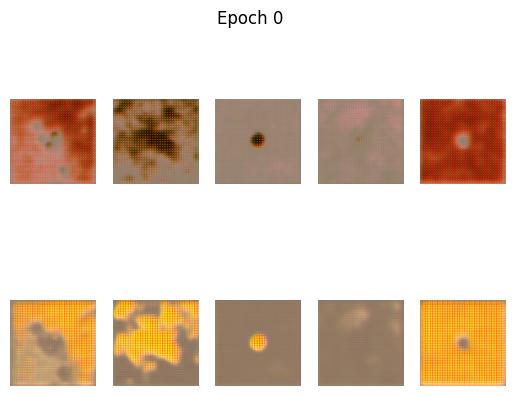

Epoch [1/1000], Step [0/197], Gen G Loss: 0.6579, Gen F Loss: 1.3807, Disc X Loss: 0.0206, Disc Y Loss: 2.1559
Epoch [1/1000], Step [100/197], Gen G Loss: 0.7792, Gen F Loss: 1.1962, Disc X Loss: 0.4342, Disc Y Loss: 0.1289
Epoch [2/1000], Step [0/197], Gen G Loss: 1.8299, Gen F Loss: 1.4678, Disc X Loss: 1.3000, Disc Y Loss: 0.3033
Epoch [2/1000], Step [100/197], Gen G Loss: 0.6461, Gen F Loss: 0.8691, Disc X Loss: 0.0848, Disc Y Loss: 0.1813
Epoch [3/1000], Step [0/197], Gen G Loss: 1.0244, Gen F Loss: 1.2282, Disc X Loss: 0.1194, Disc Y Loss: 0.1004
Epoch [3/1000], Step [100/197], Gen G Loss: 0.6584, Gen F Loss: 0.6649, Disc X Loss: 0.1602, Disc Y Loss: 0.1833
Epoch [4/1000], Step [0/197], Gen G Loss: 0.6371, Gen F Loss: 1.4054, Disc X Loss: 0.0451, Disc Y Loss: 0.2060
Epoch [4/1000], Step [100/197], Gen G Loss: 0.4987, Gen F Loss: 1.1415, Disc X Loss: 0.0657, Disc Y Loss: 0.4177
Epoch [5/1000], Step [0/197], Gen G Loss: 1.6305, Gen F Loss: 0.4420, Disc X Loss: 0.4055, Disc Y Loss: 

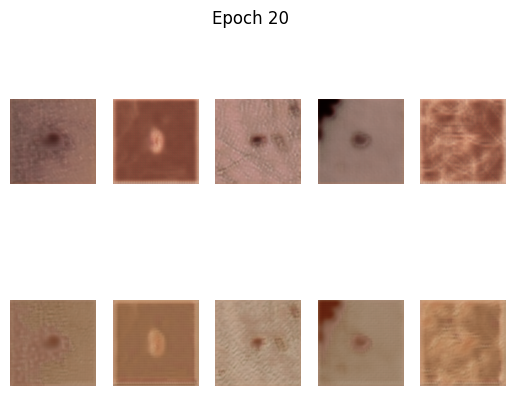

Epoch [21/1000], Step [0/197], Gen G Loss: 0.7287, Gen F Loss: 0.4854, Disc X Loss: 0.3419, Disc Y Loss: 0.1448
Epoch [21/1000], Step [100/197], Gen G Loss: 0.3153, Gen F Loss: 0.3292, Disc X Loss: 0.5599, Disc Y Loss: 0.6654
Epoch [22/1000], Step [0/197], Gen G Loss: 0.5347, Gen F Loss: 0.3829, Disc X Loss: 1.0338, Disc Y Loss: 0.2133
Epoch [22/1000], Step [100/197], Gen G Loss: 1.2009, Gen F Loss: 1.0536, Disc X Loss: 0.8696, Disc Y Loss: 0.2610
Epoch [23/1000], Step [0/197], Gen G Loss: 0.2152, Gen F Loss: 1.7277, Disc X Loss: 0.0429, Disc Y Loss: 1.0131
Epoch [23/1000], Step [100/197], Gen G Loss: 1.7602, Gen F Loss: 0.6487, Disc X Loss: 1.5121, Disc Y Loss: 1.3880
Epoch [24/1000], Step [0/197], Gen G Loss: 0.3270, Gen F Loss: 0.9719, Disc X Loss: 1.2601, Disc Y Loss: 0.4757
Epoch [24/1000], Step [100/197], Gen G Loss: 0.9422, Gen F Loss: 0.6904, Disc X Loss: 0.7789, Disc Y Loss: 1.2636
Epoch [25/1000], Step [0/197], Gen G Loss: 0.8123, Gen F Loss: 0.3067, Disc X Loss: 1.6363, Disc

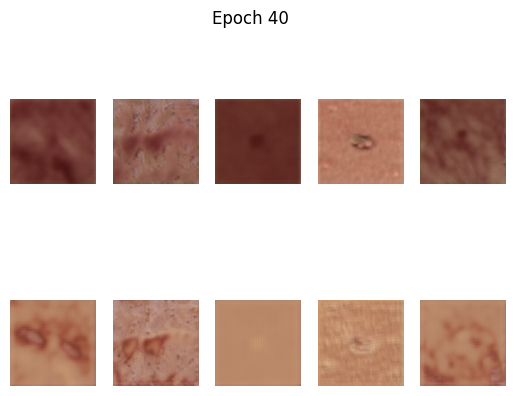

Epoch [41/1000], Step [0/197], Gen G Loss: 1.0841, Gen F Loss: 0.6792, Disc X Loss: 1.2110, Disc Y Loss: 0.2342
Epoch [41/1000], Step [100/197], Gen G Loss: 1.2942, Gen F Loss: 0.2270, Disc X Loss: 0.7582, Disc Y Loss: 0.0783
Epoch [42/1000], Step [0/197], Gen G Loss: 0.2026, Gen F Loss: 0.1135, Disc X Loss: 1.7480, Disc Y Loss: 1.0000
Epoch [42/1000], Step [100/197], Gen G Loss: 0.1631, Gen F Loss: 0.1764, Disc X Loss: 1.1728, Disc Y Loss: 1.2100
Epoch [43/1000], Step [0/197], Gen G Loss: 1.2874, Gen F Loss: 0.7826, Disc X Loss: 0.1100, Disc Y Loss: 0.0398
Epoch [43/1000], Step [100/197], Gen G Loss: 1.3522, Gen F Loss: 0.6509, Disc X Loss: 0.1765, Disc Y Loss: 2.6627
Epoch [44/1000], Step [0/197], Gen G Loss: 1.4127, Gen F Loss: 0.3549, Disc X Loss: 0.6968, Disc Y Loss: 0.0134
Epoch [44/1000], Step [100/197], Gen G Loss: 0.8520, Gen F Loss: 1.9068, Disc X Loss: 0.0153, Disc Y Loss: 0.0904
Epoch [45/1000], Step [0/197], Gen G Loss: 1.6436, Gen F Loss: 0.1513, Disc X Loss: 1.7059, Disc

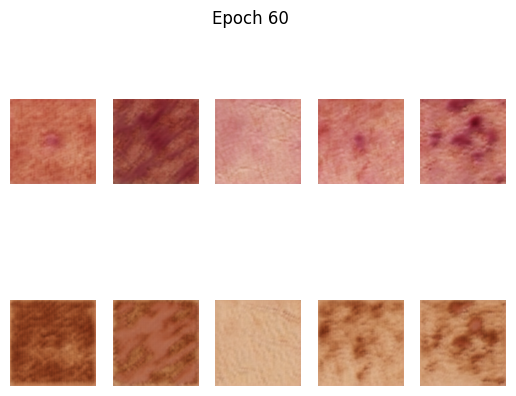

Epoch [61/1000], Step [0/197], Gen G Loss: 0.3136, Gen F Loss: 0.6222, Disc X Loss: 0.3753, Disc Y Loss: 1.3970
Epoch [61/1000], Step [100/197], Gen G Loss: 0.5131, Gen F Loss: 1.3474, Disc X Loss: 0.0140, Disc Y Loss: 0.2791
Epoch [62/1000], Step [0/197], Gen G Loss: 0.2899, Gen F Loss: 0.4435, Disc X Loss: 0.7750, Disc Y Loss: 0.7116
Epoch [62/1000], Step [100/197], Gen G Loss: 0.3164, Gen F Loss: 0.7669, Disc X Loss: 0.2127, Disc Y Loss: 0.8502
Epoch [63/1000], Step [0/197], Gen G Loss: 1.7753, Gen F Loss: 0.7535, Disc X Loss: 0.0933, Disc Y Loss: 0.5997
Epoch [63/1000], Step [100/197], Gen G Loss: 1.1271, Gen F Loss: 1.1186, Disc X Loss: 1.2807, Disc Y Loss: 0.0635
Epoch [64/1000], Step [0/197], Gen G Loss: 1.2729, Gen F Loss: 0.6758, Disc X Loss: 0.1409, Disc Y Loss: 0.0463
Epoch [64/1000], Step [100/197], Gen G Loss: 1.0351, Gen F Loss: 0.6075, Disc X Loss: 0.1850, Disc Y Loss: 1.4018
Epoch [65/1000], Step [0/197], Gen G Loss: 0.9812, Gen F Loss: 0.4331, Disc X Loss: 0.6482, Disc

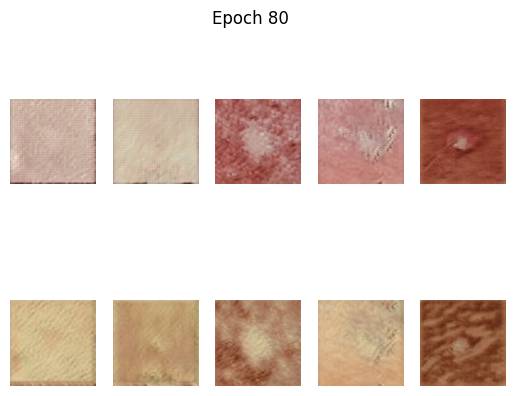

Epoch [81/1000], Step [0/197], Gen G Loss: 0.5495, Gen F Loss: 1.5317, Disc X Loss: 0.0197, Disc Y Loss: 0.3808
Epoch [81/1000], Step [100/197], Gen G Loss: 1.2208, Gen F Loss: 1.5098, Disc X Loss: 0.2287, Disc Y Loss: 0.0365
Epoch [82/1000], Step [0/197], Gen G Loss: 2.3635, Gen F Loss: 0.3110, Disc X Loss: 0.6486, Disc Y Loss: 0.1968
Epoch [82/1000], Step [100/197], Gen G Loss: 0.4874, Gen F Loss: 1.6920, Disc X Loss: 0.0170, Disc Y Loss: 1.1473
Epoch [83/1000], Step [0/197], Gen G Loss: 0.7620, Gen F Loss: 0.3773, Disc X Loss: 0.6619, Disc Y Loss: 0.1799
Epoch [83/1000], Step [100/197], Gen G Loss: 1.8642, Gen F Loss: 1.0273, Disc X Loss: 0.1145, Disc Y Loss: 0.0058
Epoch [84/1000], Step [0/197], Gen G Loss: 1.4409, Gen F Loss: 1.0597, Disc X Loss: 0.0998, Disc Y Loss: 0.0534
Epoch [84/1000], Step [100/197], Gen G Loss: 0.6549, Gen F Loss: 1.0800, Disc X Loss: 0.0950, Disc Y Loss: 0.2611
Epoch [85/1000], Step [0/197], Gen G Loss: 0.6739, Gen F Loss: 1.8172, Disc X Loss: 0.0113, Disc

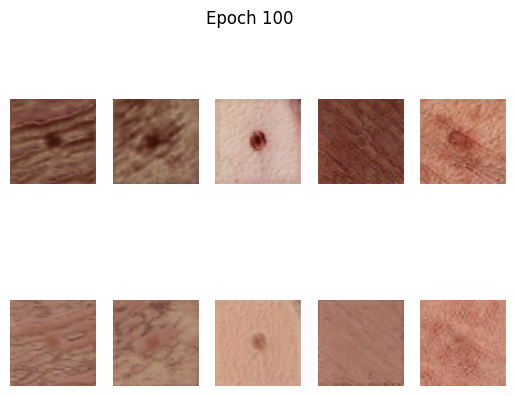

Epoch [101/1000], Step [0/197], Gen G Loss: 2.6045, Gen F Loss: 1.5372, Disc X Loss: 0.0083, Disc Y Loss: 0.0637
Epoch [101/1000], Step [100/197], Gen G Loss: 0.4395, Gen F Loss: 1.0783, Disc X Loss: 0.2285, Disc Y Loss: 0.4349
Epoch [102/1000], Step [0/197], Gen G Loss: 0.4485, Gen F Loss: 1.8064, Disc X Loss: 0.9577, Disc Y Loss: 0.5596
Epoch [102/1000], Step [100/197], Gen G Loss: 1.1336, Gen F Loss: 1.7692, Disc X Loss: 0.0039, Disc Y Loss: 0.0742
Epoch [103/1000], Step [0/197], Gen G Loss: 1.5859, Gen F Loss: 1.8626, Disc X Loss: 0.0297, Disc Y Loss: 0.0242
Epoch [103/1000], Step [100/197], Gen G Loss: 0.8719, Gen F Loss: 1.1005, Disc X Loss: 0.0486, Disc Y Loss: 0.1330
Epoch [104/1000], Step [0/197], Gen G Loss: 0.7233, Gen F Loss: 1.1861, Disc X Loss: 0.1667, Disc Y Loss: 0.1355
Epoch [104/1000], Step [100/197], Gen G Loss: 1.9275, Gen F Loss: 1.3183, Disc X Loss: 1.0878, Disc Y Loss: 0.0048
Epoch [105/1000], Step [0/197], Gen G Loss: 2.2525, Gen F Loss: 1.6258, Disc X Loss: 0.0

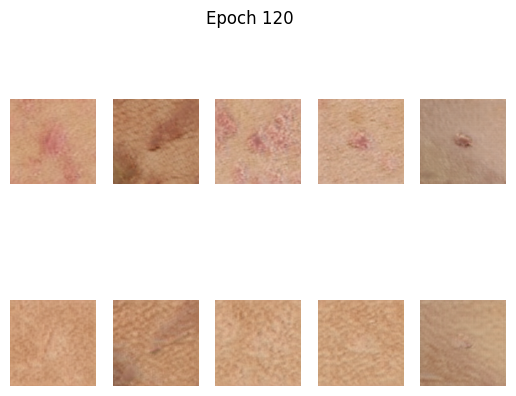

Epoch [121/1000], Step [0/197], Gen G Loss: 1.8571, Gen F Loss: 1.6645, Disc X Loss: 0.0045, Disc Y Loss: 0.0419
Epoch [121/1000], Step [100/197], Gen G Loss: 1.7462, Gen F Loss: 2.0268, Disc X Loss: 0.0027, Disc Y Loss: 0.0182
Epoch [122/1000], Step [0/197], Gen G Loss: 1.3514, Gen F Loss: 0.9062, Disc X Loss: 0.1278, Disc Y Loss: 0.0845
Epoch [122/1000], Step [100/197], Gen G Loss: 2.1288, Gen F Loss: 1.4348, Disc X Loss: 0.1169, Disc Y Loss: 0.0064
Epoch [123/1000], Step [0/197], Gen G Loss: 0.6513, Gen F Loss: 2.2134, Disc X Loss: 0.0013, Disc Y Loss: 0.2909
Epoch [123/1000], Step [100/197], Gen G Loss: 1.2721, Gen F Loss: 1.7581, Disc X Loss: 0.0037, Disc Y Loss: 0.0181
Epoch [124/1000], Step [0/197], Gen G Loss: 0.9639, Gen F Loss: 1.0816, Disc X Loss: 0.2587, Disc Y Loss: 0.1635
Epoch [124/1000], Step [100/197], Gen G Loss: 2.0335, Gen F Loss: 2.0427, Disc X Loss: 0.0104, Disc Y Loss: 0.0038
Epoch [125/1000], Step [0/197], Gen G Loss: 3.1249, Gen F Loss: 2.1427, Disc X Loss: 0.0

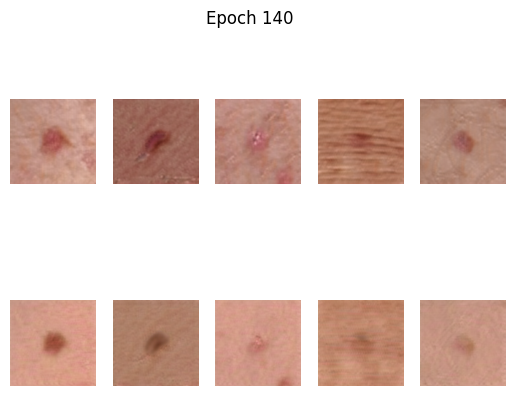

Epoch [141/1000], Step [0/197], Gen G Loss: 1.7214, Gen F Loss: 2.7371, Disc X Loss: 0.0001, Disc Y Loss: 0.0089
Epoch [141/1000], Step [100/197], Gen G Loss: 1.5846, Gen F Loss: 1.2391, Disc X Loss: 0.0344, Disc Y Loss: 0.0092
Epoch [142/1000], Step [0/197], Gen G Loss: 0.7819, Gen F Loss: 2.1855, Disc X Loss: 0.0010, Disc Y Loss: 0.2999
Epoch [142/1000], Step [100/197], Gen G Loss: 1.4380, Gen F Loss: 2.4563, Disc X Loss: 0.1512, Disc Y Loss: 0.0147
Epoch [143/1000], Step [0/197], Gen G Loss: 1.3167, Gen F Loss: 1.8690, Disc X Loss: 0.0639, Disc Y Loss: 0.0485
Epoch [143/1000], Step [100/197], Gen G Loss: 1.6703, Gen F Loss: 1.7531, Disc X Loss: 0.0044, Disc Y Loss: 0.0058
Epoch [144/1000], Step [0/197], Gen G Loss: 2.2631, Gen F Loss: 1.7938, Disc X Loss: 0.0033, Disc Y Loss: 0.0047
Epoch [144/1000], Step [100/197], Gen G Loss: 1.8330, Gen F Loss: 1.9757, Disc X Loss: 0.0019, Disc Y Loss: 0.0620
Epoch [145/1000], Step [0/197], Gen G Loss: 1.0207, Gen F Loss: 2.4998, Disc X Loss: 0.0

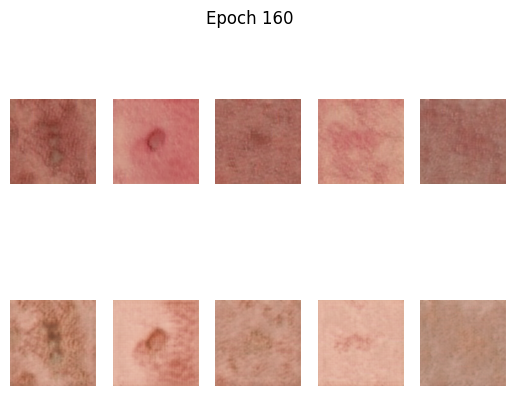

Epoch [161/1000], Step [0/197], Gen G Loss: 2.2105, Gen F Loss: 1.8623, Disc X Loss: 0.0310, Disc Y Loss: 0.0013
Epoch [161/1000], Step [100/197], Gen G Loss: 2.7554, Gen F Loss: 1.5590, Disc X Loss: 0.0245, Disc Y Loss: 0.0154
Epoch [162/1000], Step [0/197], Gen G Loss: 1.6749, Gen F Loss: 1.2584, Disc X Loss: 0.0199, Disc Y Loss: 0.0259
Epoch [162/1000], Step [100/197], Gen G Loss: 2.0813, Gen F Loss: 2.3377, Disc X Loss: 0.0033, Disc Y Loss: 0.0030
Epoch [163/1000], Step [0/197], Gen G Loss: 3.2612, Gen F Loss: 1.1482, Disc X Loss: 0.1237, Disc Y Loss: 0.0155
Epoch [163/1000], Step [100/197], Gen G Loss: 1.3706, Gen F Loss: 0.8088, Disc X Loss: 0.1913, Disc Y Loss: 0.0297
Epoch [164/1000], Step [0/197], Gen G Loss: 1.5264, Gen F Loss: 1.3179, Disc X Loss: 0.0711, Disc Y Loss: 0.0149
Epoch [164/1000], Step [100/197], Gen G Loss: 2.2543, Gen F Loss: 2.1690, Disc X Loss: 0.0078, Disc Y Loss: 0.0110
Epoch [165/1000], Step [0/197], Gen G Loss: 2.3416, Gen F Loss: 1.8212, Disc X Loss: 0.0

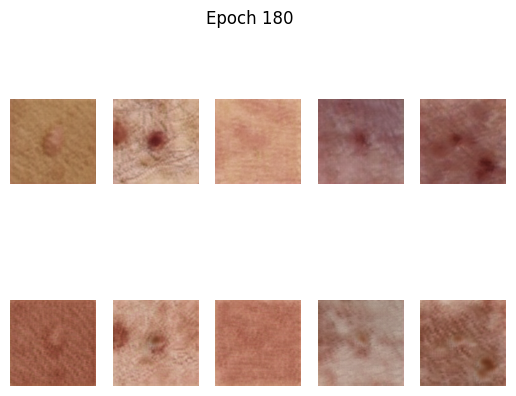

Epoch [181/1000], Step [0/197], Gen G Loss: 2.1543, Gen F Loss: 2.5092, Disc X Loss: 0.0010, Disc Y Loss: 0.0009
Epoch [181/1000], Step [100/197], Gen G Loss: 1.3332, Gen F Loss: 1.3321, Disc X Loss: 0.0115, Disc Y Loss: 0.0272
Epoch [182/1000], Step [0/197], Gen G Loss: 1.6877, Gen F Loss: 2.4425, Disc X Loss: 0.0006, Disc Y Loss: 1.2868
Epoch [182/1000], Step [100/197], Gen G Loss: 0.6675, Gen F Loss: 2.0750, Disc X Loss: 0.0014, Disc Y Loss: 0.1969
Epoch [183/1000], Step [0/197], Gen G Loss: 1.0105, Gen F Loss: 0.8536, Disc X Loss: 0.1399, Disc Y Loss: 0.1176
Epoch [183/1000], Step [100/197], Gen G Loss: 0.9595, Gen F Loss: 1.2453, Disc X Loss: 0.8622, Disc Y Loss: 0.1573
Epoch [184/1000], Step [0/197], Gen G Loss: 1.4760, Gen F Loss: 0.6656, Disc X Loss: 0.3025, Disc Y Loss: 0.0158
Epoch [184/1000], Step [100/197], Gen G Loss: 2.5594, Gen F Loss: 1.7332, Disc X Loss: 0.0087, Disc Y Loss: 0.2500
Epoch [185/1000], Step [0/197], Gen G Loss: 1.9581, Gen F Loss: 0.6716, Disc X Loss: 0.2

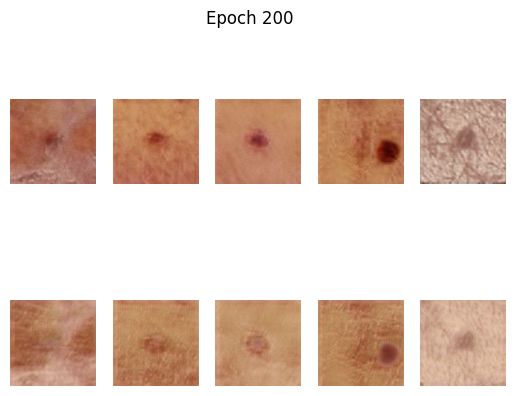

Epoch [201/1000], Step [0/197], Gen G Loss: 2.0349, Gen F Loss: 1.2025, Disc X Loss: 0.0348, Disc Y Loss: 0.0186
Epoch [201/1000], Step [100/197], Gen G Loss: 3.6465, Gen F Loss: 2.1224, Disc X Loss: 0.0007, Disc Y Loss: 0.0105
Epoch [202/1000], Step [0/197], Gen G Loss: 1.8895, Gen F Loss: 0.9056, Disc X Loss: 0.1545, Disc Y Loss: 0.0069
Epoch [202/1000], Step [100/197], Gen G Loss: 0.9354, Gen F Loss: 1.4286, Disc X Loss: 0.0131, Disc Y Loss: 0.0914
Epoch [203/1000], Step [0/197], Gen G Loss: 2.7470, Gen F Loss: 2.1597, Disc X Loss: 0.0011, Disc Y Loss: 0.0177
Epoch [203/1000], Step [100/197], Gen G Loss: 2.9793, Gen F Loss: 0.6943, Disc X Loss: 0.2595, Disc Y Loss: 0.0019
Epoch [204/1000], Step [0/197], Gen G Loss: 0.5962, Gen F Loss: 1.9189, Disc X Loss: 0.0021, Disc Y Loss: 0.5060
Epoch [204/1000], Step [100/197], Gen G Loss: 1.2361, Gen F Loss: 1.2115, Disc X Loss: 0.0393, Disc Y Loss: 0.0798
Epoch [205/1000], Step [0/197], Gen G Loss: 4.0906, Gen F Loss: 1.2858, Disc X Loss: 0.0

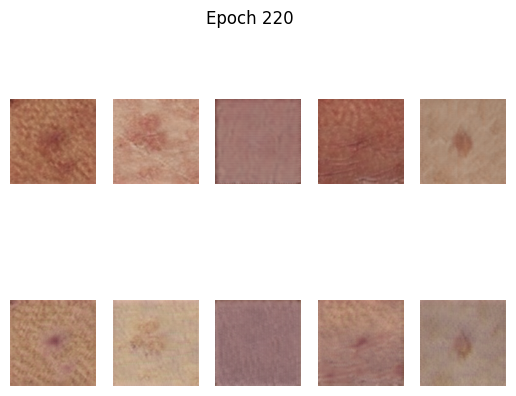

Epoch [221/1000], Step [0/197], Gen G Loss: 0.6246, Gen F Loss: 1.8000, Disc X Loss: 0.0080, Disc Y Loss: 0.3609
Epoch [221/1000], Step [100/197], Gen G Loss: 1.4829, Gen F Loss: 2.3025, Disc X Loss: 0.0005, Disc Y Loss: 0.0580
Epoch [222/1000], Step [0/197], Gen G Loss: 1.7516, Gen F Loss: 2.1089, Disc X Loss: 0.0024, Disc Y Loss: 0.0164
Epoch [222/1000], Step [100/197], Gen G Loss: 1.9818, Gen F Loss: 1.2097, Disc X Loss: 0.0421, Disc Y Loss: 0.0036
Epoch [223/1000], Step [0/197], Gen G Loss: 1.9954, Gen F Loss: 1.9241, Disc X Loss: 0.0034, Disc Y Loss: 0.0024
Epoch [223/1000], Step [100/197], Gen G Loss: 2.6598, Gen F Loss: 2.3432, Disc X Loss: 0.0006, Disc Y Loss: 0.0123
Epoch [224/1000], Step [0/197], Gen G Loss: 2.6188, Gen F Loss: 2.2590, Disc X Loss: 0.0005, Disc Y Loss: 0.0264
Epoch [224/1000], Step [100/197], Gen G Loss: 2.9007, Gen F Loss: 2.2617, Disc X Loss: 0.0490, Disc Y Loss: 0.0105
Epoch [225/1000], Step [0/197], Gen G Loss: 1.4151, Gen F Loss: 1.9622, Disc X Loss: 0.0

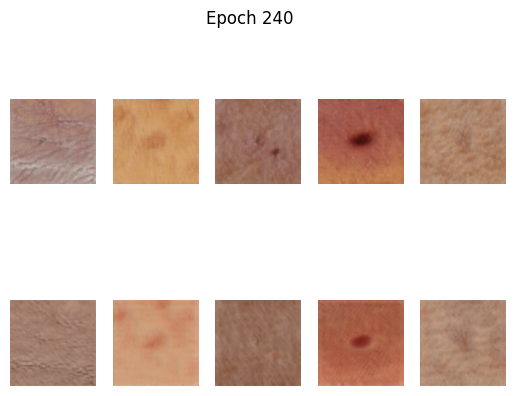

Epoch [241/1000], Step [0/197], Gen G Loss: 2.6858, Gen F Loss: 1.6711, Disc X Loss: 0.0052, Disc Y Loss: 0.0189
Epoch [241/1000], Step [100/197], Gen G Loss: 2.7942, Gen F Loss: 1.0177, Disc X Loss: 0.1487, Disc Y Loss: 0.0040
Epoch [242/1000], Step [0/197], Gen G Loss: 2.9645, Gen F Loss: 3.2070, Disc X Loss: 0.0000, Disc Y Loss: 0.0042
Epoch [242/1000], Step [100/197], Gen G Loss: 3.1646, Gen F Loss: 2.1873, Disc X Loss: 0.0018, Disc Y Loss: 0.0002
Epoch [243/1000], Step [0/197], Gen G Loss: 1.9789, Gen F Loss: 1.3011, Disc X Loss: 0.0252, Disc Y Loss: 0.0109
Epoch [243/1000], Step [100/197], Gen G Loss: 1.6780, Gen F Loss: 2.1296, Disc X Loss: 0.0007, Disc Y Loss: 0.0905
Epoch [244/1000], Step [0/197], Gen G Loss: 3.0947, Gen F Loss: 1.5275, Disc X Loss: 0.0123, Disc Y Loss: 0.0008
Epoch [244/1000], Step [100/197], Gen G Loss: 3.0031, Gen F Loss: 2.0716, Disc X Loss: 0.0082, Disc Y Loss: 0.0001
Epoch [245/1000], Step [0/197], Gen G Loss: 4.0104, Gen F Loss: 2.2616, Disc X Loss: 0.0

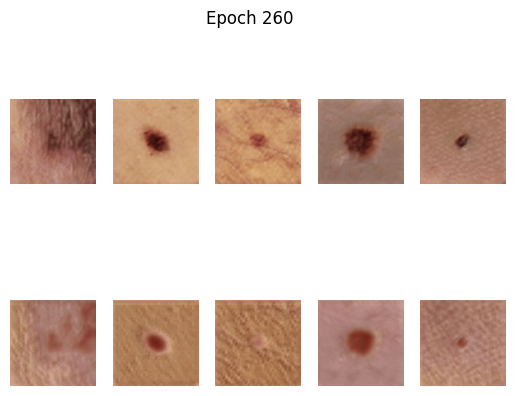

Epoch [261/1000], Step [0/197], Gen G Loss: 1.7753, Gen F Loss: 3.3276, Disc X Loss: 0.0000, Disc Y Loss: 0.0167
Epoch [261/1000], Step [100/197], Gen G Loss: 3.2328, Gen F Loss: 1.0551, Disc X Loss: 0.0745, Disc Y Loss: 0.0057
Epoch [262/1000], Step [0/197], Gen G Loss: 1.9812, Gen F Loss: 2.3110, Disc X Loss: 0.0043, Disc Y Loss: 0.0156
Epoch [262/1000], Step [100/197], Gen G Loss: 1.9468, Gen F Loss: 2.2128, Disc X Loss: 0.0119, Disc Y Loss: 0.0039
Epoch [263/1000], Step [0/197], Gen G Loss: 2.1679, Gen F Loss: 2.7655, Disc X Loss: 0.0005, Disc Y Loss: 0.0950
Epoch [263/1000], Step [100/197], Gen G Loss: 2.1578, Gen F Loss: 2.4238, Disc X Loss: 0.0006, Disc Y Loss: 0.0046
Epoch [264/1000], Step [0/197], Gen G Loss: 2.4432, Gen F Loss: 1.3971, Disc X Loss: 0.0185, Disc Y Loss: 0.0012
Epoch [264/1000], Step [100/197], Gen G Loss: 2.8319, Gen F Loss: 0.7161, Disc X Loss: 0.3019, Disc Y Loss: 0.0115
Epoch [265/1000], Step [0/197], Gen G Loss: 1.0385, Gen F Loss: 1.2985, Disc X Loss: 0.0

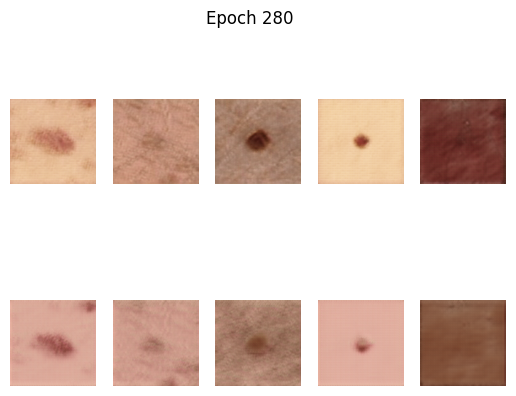

Epoch [281/1000], Step [0/197], Gen G Loss: 2.4936, Gen F Loss: 1.4589, Disc X Loss: 0.0126, Disc Y Loss: 0.0030
Epoch [281/1000], Step [100/197], Gen G Loss: 1.7863, Gen F Loss: 2.2256, Disc X Loss: 0.0274, Disc Y Loss: 0.0042
Epoch [282/1000], Step [0/197], Gen G Loss: 2.1456, Gen F Loss: 2.8751, Disc X Loss: 0.0040, Disc Y Loss: 0.0050
Epoch [282/1000], Step [100/197], Gen G Loss: 3.1347, Gen F Loss: 1.9214, Disc X Loss: 0.0041, Disc Y Loss: 0.0001
Epoch [283/1000], Step [0/197], Gen G Loss: 2.5103, Gen F Loss: 1.6004, Disc X Loss: 0.0166, Disc Y Loss: 0.0026
Epoch [283/1000], Step [100/197], Gen G Loss: 1.4678, Gen F Loss: 2.2343, Disc X Loss: 0.0038, Disc Y Loss: 0.0549
Epoch [284/1000], Step [0/197], Gen G Loss: 2.5257, Gen F Loss: 2.6523, Disc X Loss: 0.0074, Disc Y Loss: 0.0009
Epoch [284/1000], Step [100/197], Gen G Loss: 3.1301, Gen F Loss: 3.8837, Disc X Loss: 5.7249, Disc Y Loss: 0.0015
Epoch [285/1000], Step [0/197], Gen G Loss: 2.5711, Gen F Loss: 1.6628, Disc X Loss: 0.0

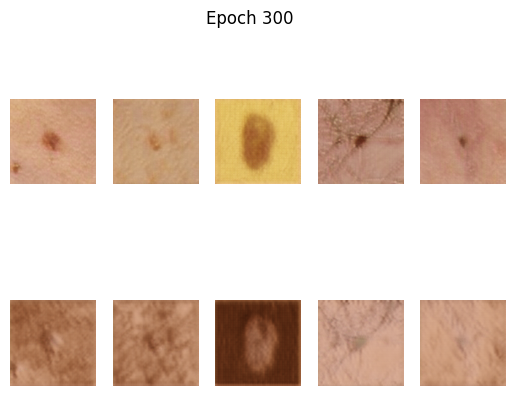

Epoch [301/1000], Step [0/197], Gen G Loss: 3.2001, Gen F Loss: 2.3555, Disc X Loss: 0.0004, Disc Y Loss: 0.0004
Epoch [301/1000], Step [100/197], Gen G Loss: 1.1800, Gen F Loss: 2.4763, Disc X Loss: 0.0003, Disc Y Loss: 0.0810
Epoch [302/1000], Step [0/197], Gen G Loss: 2.2901, Gen F Loss: 2.1254, Disc X Loss: 0.0024, Disc Y Loss: 0.0593
Epoch [302/1000], Step [100/197], Gen G Loss: 2.0135, Gen F Loss: 2.2415, Disc X Loss: 0.2337, Disc Y Loss: 0.0058
Epoch [303/1000], Step [0/197], Gen G Loss: 1.5668, Gen F Loss: 2.6702, Disc X Loss: 0.0005, Disc Y Loss: 0.0349
Epoch [303/1000], Step [100/197], Gen G Loss: 2.6088, Gen F Loss: 1.1227, Disc X Loss: 0.0626, Disc Y Loss: 0.0513
Epoch [304/1000], Step [0/197], Gen G Loss: 3.7451, Gen F Loss: 2.8929, Disc X Loss: 0.0007, Disc Y Loss: 0.0017
Epoch [304/1000], Step [100/197], Gen G Loss: 2.6177, Gen F Loss: 2.1712, Disc X Loss: 0.0017, Disc Y Loss: 0.0020
Epoch [305/1000], Step [0/197], Gen G Loss: 2.0930, Gen F Loss: 2.9964, Disc X Loss: 0.0

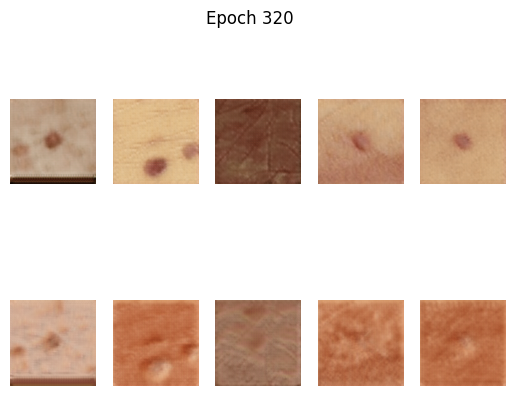

Epoch [321/1000], Step [0/197], Gen G Loss: 2.5363, Gen F Loss: 2.4132, Disc X Loss: 0.0010, Disc Y Loss: 0.0029
Epoch [321/1000], Step [100/197], Gen G Loss: 2.7345, Gen F Loss: 1.9709, Disc X Loss: 0.0018, Disc Y Loss: 0.0057
Epoch [322/1000], Step [0/197], Gen G Loss: 1.4506, Gen F Loss: 1.9492, Disc X Loss: 0.0063, Disc Y Loss: 0.0163
Epoch [322/1000], Step [100/197], Gen G Loss: 3.0931, Gen F Loss: 1.7023, Disc X Loss: 0.0512, Disc Y Loss: 0.0002
Epoch [323/1000], Step [0/197], Gen G Loss: 2.7051, Gen F Loss: 2.9103, Disc X Loss: 0.0002, Disc Y Loss: 0.0039
Epoch [323/1000], Step [100/197], Gen G Loss: 3.2198, Gen F Loss: 2.8365, Disc X Loss: 0.1172, Disc Y Loss: 0.0001
Epoch [324/1000], Step [0/197], Gen G Loss: 3.0344, Gen F Loss: 2.8142, Disc X Loss: 0.0004, Disc Y Loss: 0.0006
Epoch [324/1000], Step [100/197], Gen G Loss: 1.7893, Gen F Loss: 2.6107, Disc X Loss: 0.0002, Disc Y Loss: 0.0075
Epoch [325/1000], Step [0/197], Gen G Loss: 3.4386, Gen F Loss: 1.9538, Disc X Loss: 0.0

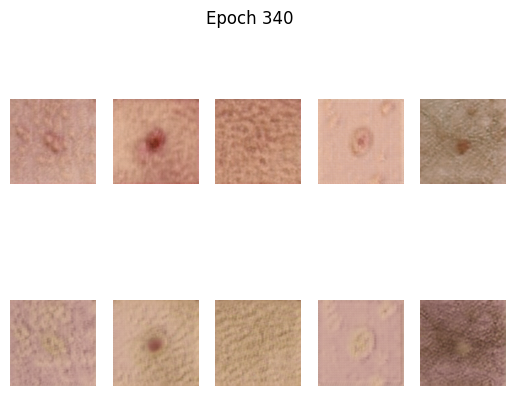

Epoch [341/1000], Step [0/197], Gen G Loss: 1.9564, Gen F Loss: 2.7701, Disc X Loss: 0.0003, Disc Y Loss: 0.0047
Epoch [341/1000], Step [100/197], Gen G Loss: 3.0198, Gen F Loss: 4.1769, Disc X Loss: 0.0001, Disc Y Loss: 0.0042
Epoch [342/1000], Step [0/197], Gen G Loss: 1.6549, Gen F Loss: 2.8014, Disc X Loss: 0.0004, Disc Y Loss: 0.0111
Epoch [342/1000], Step [100/197], Gen G Loss: 2.1232, Gen F Loss: 2.2726, Disc X Loss: 0.0006, Disc Y Loss: 0.0061
Epoch [343/1000], Step [0/197], Gen G Loss: 3.5844, Gen F Loss: 2.1353, Disc X Loss: 0.0015, Disc Y Loss: 0.0084
Epoch [343/1000], Step [100/197], Gen G Loss: 4.4855, Gen F Loss: 2.5958, Disc X Loss: 0.0001, Disc Y Loss: 0.7755
Epoch [344/1000], Step [0/197], Gen G Loss: 4.6504, Gen F Loss: 1.8132, Disc X Loss: 0.0036, Disc Y Loss: 0.0003
Epoch [344/1000], Step [100/197], Gen G Loss: 2.8662, Gen F Loss: 2.3191, Disc X Loss: 0.0016, Disc Y Loss: 0.0020
Epoch [345/1000], Step [0/197], Gen G Loss: 1.2834, Gen F Loss: 2.4129, Disc X Loss: 0.0

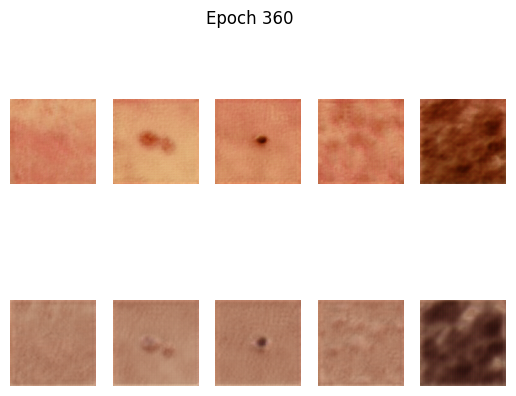

Epoch [361/1000], Step [0/197], Gen G Loss: 3.1420, Gen F Loss: 2.9024, Disc X Loss: 0.0010, Disc Y Loss: 0.0041
Epoch [361/1000], Step [100/197], Gen G Loss: 2.3118, Gen F Loss: 2.4028, Disc X Loss: 0.0004, Disc Y Loss: 0.0005
Epoch [362/1000], Step [0/197], Gen G Loss: 2.8960, Gen F Loss: 1.8336, Disc X Loss: 0.0083, Disc Y Loss: 0.0003
Epoch [362/1000], Step [100/197], Gen G Loss: 2.3885, Gen F Loss: 3.6954, Disc X Loss: 0.0001, Disc Y Loss: 0.0008
Epoch [363/1000], Step [0/197], Gen G Loss: 2.8998, Gen F Loss: 2.2026, Disc X Loss: 0.0008, Disc Y Loss: 0.0004
Epoch [363/1000], Step [100/197], Gen G Loss: 1.6876, Gen F Loss: 2.7649, Disc X Loss: 0.0011, Disc Y Loss: 0.0127
Epoch [364/1000], Step [0/197], Gen G Loss: 3.5884, Gen F Loss: 2.1186, Disc X Loss: 0.0031, Disc Y Loss: 0.0000
Epoch [364/1000], Step [100/197], Gen G Loss: 1.9085, Gen F Loss: 2.1852, Disc X Loss: 0.0010, Disc Y Loss: 0.0050
Epoch [365/1000], Step [0/197], Gen G Loss: 3.7562, Gen F Loss: 2.8012, Disc X Loss: 0.0

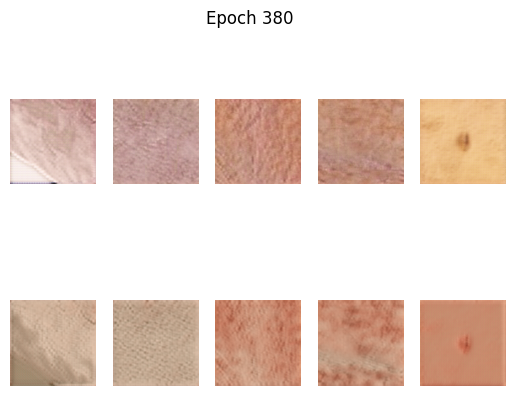

Epoch [381/1000], Step [0/197], Gen G Loss: 2.4234, Gen F Loss: 2.1335, Disc X Loss: 0.0036, Disc Y Loss: 0.0421
Epoch [381/1000], Step [100/197], Gen G Loss: 2.6063, Gen F Loss: 0.6727, Disc X Loss: 0.1748, Disc Y Loss: 0.0220
Epoch [382/1000], Step [0/197], Gen G Loss: 2.1452, Gen F Loss: 1.7328, Disc X Loss: 0.0055, Disc Y Loss: 0.0317
Epoch [382/1000], Step [100/197], Gen G Loss: 3.1158, Gen F Loss: 2.5612, Disc X Loss: 0.0010, Disc Y Loss: 0.0142
Epoch [383/1000], Step [0/197], Gen G Loss: 1.8413, Gen F Loss: 2.1797, Disc X Loss: 0.0398, Disc Y Loss: 0.3299
Epoch [383/1000], Step [100/197], Gen G Loss: 2.0649, Gen F Loss: 1.2822, Disc X Loss: 0.0289, Disc Y Loss: 0.0044
Epoch [384/1000], Step [0/197], Gen G Loss: 2.9703, Gen F Loss: 0.0948, Disc X Loss: 2.7096, Disc Y Loss: 0.0020
Epoch [384/1000], Step [100/197], Gen G Loss: 3.3420, Gen F Loss: 1.7222, Disc X Loss: 0.0059, Disc Y Loss: 0.0206
Epoch [385/1000], Step [0/197], Gen G Loss: 2.0311, Gen F Loss: 1.5876, Disc X Loss: 0.0

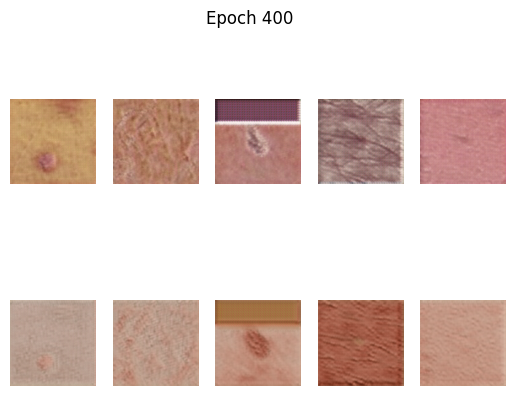

Epoch [401/1000], Step [0/197], Gen G Loss: 2.3162, Gen F Loss: 3.8462, Disc X Loss: 0.0007, Disc Y Loss: 0.0204
Epoch [401/1000], Step [100/197], Gen G Loss: 2.8474, Gen F Loss: 2.3548, Disc X Loss: 0.0011, Disc Y Loss: 0.0029
Epoch [402/1000], Step [0/197], Gen G Loss: 2.1830, Gen F Loss: 0.4975, Disc X Loss: 0.6597, Disc Y Loss: 0.0024
Epoch [402/1000], Step [100/197], Gen G Loss: 2.8351, Gen F Loss: 2.5931, Disc X Loss: 0.0084, Disc Y Loss: 0.0006
Epoch [403/1000], Step [0/197], Gen G Loss: 2.4411, Gen F Loss: 1.1765, Disc X Loss: 0.5414, Disc Y Loss: 0.0038
Epoch [403/1000], Step [100/197], Gen G Loss: 2.1388, Gen F Loss: 2.1734, Disc X Loss: 0.0579, Disc Y Loss: 0.0023
Epoch [404/1000], Step [0/197], Gen G Loss: 3.1378, Gen F Loss: 1.1560, Disc X Loss: 0.0607, Disc Y Loss: 0.0002
Epoch [404/1000], Step [100/197], Gen G Loss: 3.4114, Gen F Loss: 1.3240, Disc X Loss: 0.0296, Disc Y Loss: 0.0046
Epoch [405/1000], Step [0/197], Gen G Loss: 2.5517, Gen F Loss: 3.5934, Disc X Loss: 0.0

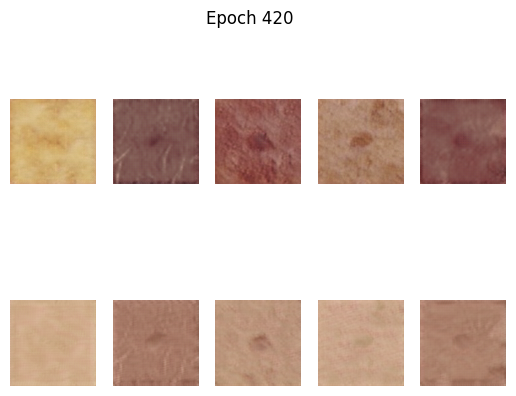

Epoch [421/1000], Step [0/197], Gen G Loss: 2.9569, Gen F Loss: 3.4126, Disc X Loss: 0.0000, Disc Y Loss: 0.0016
Epoch [421/1000], Step [100/197], Gen G Loss: 2.4526, Gen F Loss: 2.9965, Disc X Loss: 0.0322, Disc Y Loss: 0.0036
Epoch [422/1000], Step [0/197], Gen G Loss: 1.5309, Gen F Loss: 2.6954, Disc X Loss: 0.0001, Disc Y Loss: 0.0096
Epoch [422/1000], Step [100/197], Gen G Loss: 2.8485, Gen F Loss: 3.2002, Disc X Loss: 0.0031, Disc Y Loss: 0.0004
Epoch [423/1000], Step [0/197], Gen G Loss: 0.9861, Gen F Loss: 0.4313, Disc X Loss: 0.7966, Disc Y Loss: 0.1994
Epoch [423/1000], Step [100/197], Gen G Loss: 2.8455, Gen F Loss: 3.1840, Disc X Loss: 0.0000, Disc Y Loss: 0.0007
Epoch [424/1000], Step [0/197], Gen G Loss: 2.2698, Gen F Loss: 2.2896, Disc X Loss: 0.0007, Disc Y Loss: 0.0078
Epoch [424/1000], Step [100/197], Gen G Loss: 3.1005, Gen F Loss: 1.1506, Disc X Loss: 0.0877, Disc Y Loss: 0.0004
Epoch [425/1000], Step [0/197], Gen G Loss: 3.0390, Gen F Loss: 1.5508, Disc X Loss: 0.0

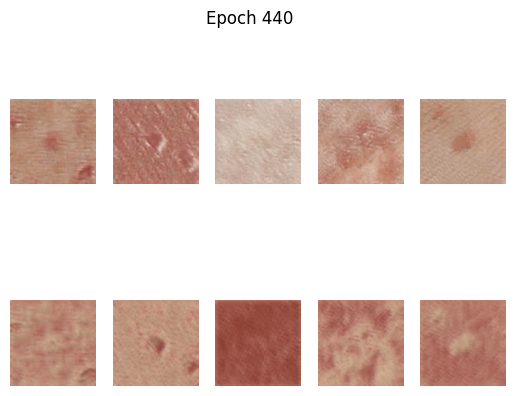

Epoch [441/1000], Step [0/197], Gen G Loss: 4.2581, Gen F Loss: 1.9504, Disc X Loss: 0.0035, Disc Y Loss: 0.0009
Epoch [441/1000], Step [100/197], Gen G Loss: 3.9211, Gen F Loss: 0.8697, Disc X Loss: 0.0897, Disc Y Loss: 0.0039
Epoch [442/1000], Step [0/197], Gen G Loss: 2.1204, Gen F Loss: 1.7567, Disc X Loss: 0.0076, Disc Y Loss: 0.0153
Epoch [442/1000], Step [100/197], Gen G Loss: 3.8591, Gen F Loss: 2.2499, Disc X Loss: 0.0014, Disc Y Loss: 0.0030
Epoch [443/1000], Step [0/197], Gen G Loss: 3.5591, Gen F Loss: 0.6249, Disc X Loss: 0.5195, Disc Y Loss: 0.0009
Epoch [443/1000], Step [100/197], Gen G Loss: 3.3369, Gen F Loss: 2.3427, Disc X Loss: 2.4396, Disc Y Loss: 0.0008
Epoch [444/1000], Step [0/197], Gen G Loss: 2.2500, Gen F Loss: 1.4984, Disc X Loss: 0.0233, Disc Y Loss: 0.0339
Epoch [444/1000], Step [100/197], Gen G Loss: 1.9954, Gen F Loss: 1.7403, Disc X Loss: 0.0135, Disc Y Loss: 0.5844
Epoch [445/1000], Step [0/197], Gen G Loss: 2.6317, Gen F Loss: 0.5186, Disc X Loss: 0.4

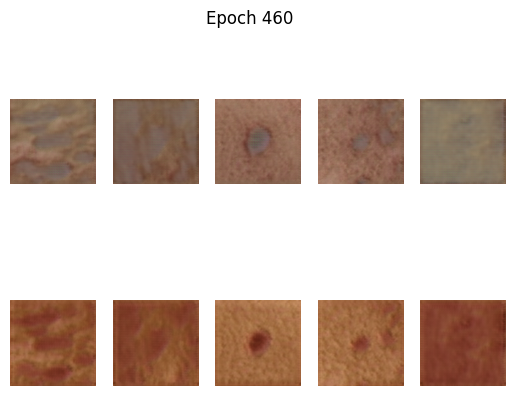

Epoch [461/1000], Step [0/197], Gen G Loss: 3.5267, Gen F Loss: 2.4067, Disc X Loss: 0.0005, Disc Y Loss: 0.0002
Epoch [461/1000], Step [100/197], Gen G Loss: 2.0616, Gen F Loss: 1.5626, Disc X Loss: 0.0085, Disc Y Loss: 0.0180
Epoch [462/1000], Step [0/197], Gen G Loss: 2.4338, Gen F Loss: 0.7546, Disc X Loss: 0.2038, Disc Y Loss: 0.0022
Epoch [462/1000], Step [100/197], Gen G Loss: 2.6249, Gen F Loss: 2.5737, Disc X Loss: 0.0337, Disc Y Loss: 0.0019
Epoch [463/1000], Step [0/197], Gen G Loss: 4.6435, Gen F Loss: 2.1599, Disc X Loss: 0.0042, Disc Y Loss: 0.0014
Epoch [463/1000], Step [100/197], Gen G Loss: 2.5951, Gen F Loss: 2.2896, Disc X Loss: 0.0217, Disc Y Loss: 0.0006
Epoch [464/1000], Step [0/197], Gen G Loss: 2.6603, Gen F Loss: 0.6954, Disc X Loss: 0.3309, Disc Y Loss: 0.0026
Epoch [464/1000], Step [100/197], Gen G Loss: 2.1161, Gen F Loss: 0.6886, Disc X Loss: 0.1664, Disc Y Loss: 0.0194
Epoch [465/1000], Step [0/197], Gen G Loss: 3.6026, Gen F Loss: 1.2297, Disc X Loss: 0.0

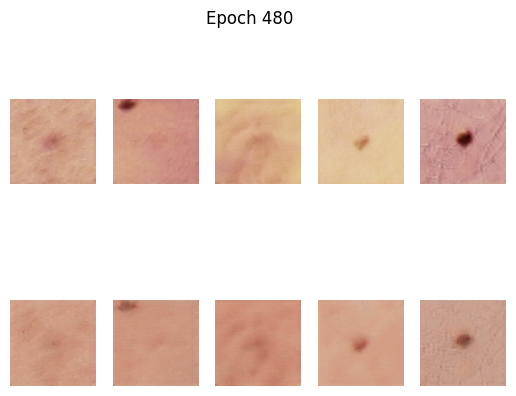

Epoch [481/1000], Step [0/197], Gen G Loss: 3.1553, Gen F Loss: 1.9049, Disc X Loss: 0.0050, Disc Y Loss: 0.0002
Epoch [481/1000], Step [100/197], Gen G Loss: 3.2420, Gen F Loss: 2.5137, Disc X Loss: 0.2856, Disc Y Loss: 0.0008
Epoch [482/1000], Step [0/197], Gen G Loss: 2.7685, Gen F Loss: 1.6940, Disc X Loss: 0.0063, Disc Y Loss: 0.0005
Epoch [482/1000], Step [100/197], Gen G Loss: 2.6702, Gen F Loss: 1.9505, Disc X Loss: 0.0012, Disc Y Loss: 0.0036
Epoch [483/1000], Step [0/197], Gen G Loss: 2.6390, Gen F Loss: 0.6452, Disc X Loss: 0.2280, Disc Y Loss: 0.0010
Epoch [483/1000], Step [100/197], Gen G Loss: 3.2705, Gen F Loss: 2.0819, Disc X Loss: 0.0017, Disc Y Loss: 0.0002
Epoch [484/1000], Step [0/197], Gen G Loss: 3.7725, Gen F Loss: 1.4718, Disc X Loss: 0.2175, Disc Y Loss: 0.0003
Epoch [484/1000], Step [100/197], Gen G Loss: 3.4251, Gen F Loss: 1.5944, Disc X Loss: 0.0263, Disc Y Loss: 0.0116
Epoch [485/1000], Step [0/197], Gen G Loss: 3.5080, Gen F Loss: 3.6502, Disc X Loss: 0.0

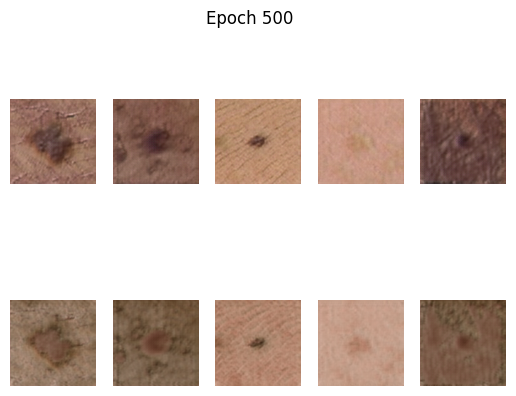

Epoch [501/1000], Step [0/197], Gen G Loss: 2.9889, Gen F Loss: 2.3008, Disc X Loss: 0.0051, Disc Y Loss: 0.0004
Epoch [501/1000], Step [100/197], Gen G Loss: 2.9890, Gen F Loss: 1.4903, Disc X Loss: 0.0178, Disc Y Loss: 0.0005
Epoch [502/1000], Step [0/197], Gen G Loss: 1.9455, Gen F Loss: 0.9126, Disc X Loss: 0.1221, Disc Y Loss: 0.2784
Epoch [502/1000], Step [100/197], Gen G Loss: 3.6301, Gen F Loss: 1.8550, Disc X Loss: 0.0096, Disc Y Loss: 0.0039
Epoch [503/1000], Step [0/197], Gen G Loss: 3.8815, Gen F Loss: 2.5304, Disc X Loss: 0.0009, Disc Y Loss: 0.0000
Epoch [503/1000], Step [100/197], Gen G Loss: 3.0436, Gen F Loss: 2.0339, Disc X Loss: 0.0009, Disc Y Loss: 0.0005
Epoch [504/1000], Step [0/197], Gen G Loss: 2.7535, Gen F Loss: 2.2557, Disc X Loss: 0.0013, Disc Y Loss: 0.0011
Epoch [504/1000], Step [100/197], Gen G Loss: 2.8852, Gen F Loss: 1.4351, Disc X Loss: 0.0173, Disc Y Loss: 0.0002
Epoch [505/1000], Step [0/197], Gen G Loss: 2.8068, Gen F Loss: 2.1691, Disc X Loss: 0.0

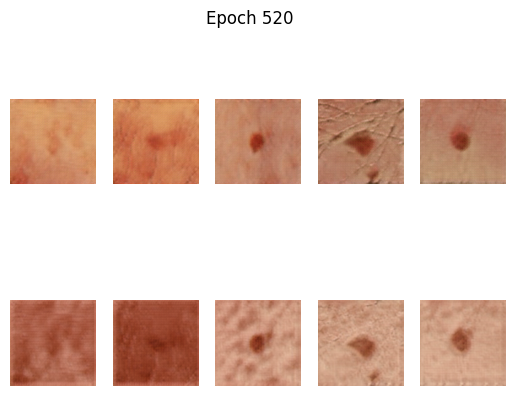

Epoch [521/1000], Step [0/197], Gen G Loss: 2.7122, Gen F Loss: 0.1798, Disc X Loss: 1.9528, Disc Y Loss: 0.0004
Epoch [521/1000], Step [100/197], Gen G Loss: 3.0570, Gen F Loss: 2.3208, Disc X Loss: 0.0003, Disc Y Loss: 0.0001
Epoch [522/1000], Step [0/197], Gen G Loss: 3.3187, Gen F Loss: 1.2512, Disc X Loss: 0.0347, Disc Y Loss: 0.0004
Epoch [522/1000], Step [100/197], Gen G Loss: 4.2364, Gen F Loss: 1.1182, Disc X Loss: 0.0561, Disc Y Loss: 0.0288
Epoch [523/1000], Step [0/197], Gen G Loss: 3.7962, Gen F Loss: 0.3806, Disc X Loss: 0.5393, Disc Y Loss: 0.0001
Epoch [523/1000], Step [100/197], Gen G Loss: 3.3690, Gen F Loss: 2.0492, Disc X Loss: 0.0087, Disc Y Loss: 0.0003
Epoch [524/1000], Step [0/197], Gen G Loss: 3.3357, Gen F Loss: 0.9383, Disc X Loss: 0.1043, Disc Y Loss: 0.0002
Epoch [524/1000], Step [100/197], Gen G Loss: 3.6112, Gen F Loss: 2.8513, Disc X Loss: 0.3080, Disc Y Loss: 0.0001
Epoch [525/1000], Step [0/197], Gen G Loss: 4.9938, Gen F Loss: 1.4477, Disc X Loss: 0.0

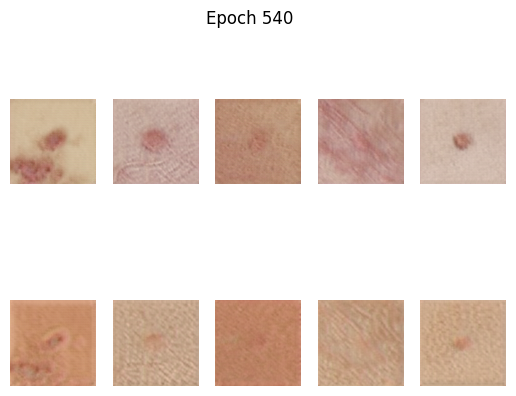

Epoch [541/1000], Step [0/197], Gen G Loss: 2.9681, Gen F Loss: 2.6561, Disc X Loss: 0.1740, Disc Y Loss: 0.0001
Epoch [541/1000], Step [100/197], Gen G Loss: 4.1326, Gen F Loss: 1.8741, Disc X Loss: 0.0039, Disc Y Loss: 0.0001
Epoch [542/1000], Step [0/197], Gen G Loss: 4.2459, Gen F Loss: 2.8078, Disc X Loss: 0.0065, Disc Y Loss: 0.0001
Epoch [542/1000], Step [100/197], Gen G Loss: 3.6327, Gen F Loss: 0.7700, Disc X Loss: 0.2016, Disc Y Loss: 0.0013
Epoch [543/1000], Step [0/197], Gen G Loss: 3.3600, Gen F Loss: 2.5817, Disc X Loss: 0.1711, Disc Y Loss: 0.0008
Epoch [543/1000], Step [100/197], Gen G Loss: 2.7065, Gen F Loss: 2.3730, Disc X Loss: 0.0315, Disc Y Loss: 0.0014
Epoch [544/1000], Step [0/197], Gen G Loss: 3.1651, Gen F Loss: 1.4346, Disc X Loss: 0.0101, Disc Y Loss: 0.0018
Epoch [544/1000], Step [100/197], Gen G Loss: 2.9315, Gen F Loss: 1.8468, Disc X Loss: 0.0027, Disc Y Loss: 0.0004
Epoch [545/1000], Step [0/197], Gen G Loss: 1.9287, Gen F Loss: 2.1930, Disc X Loss: 0.0

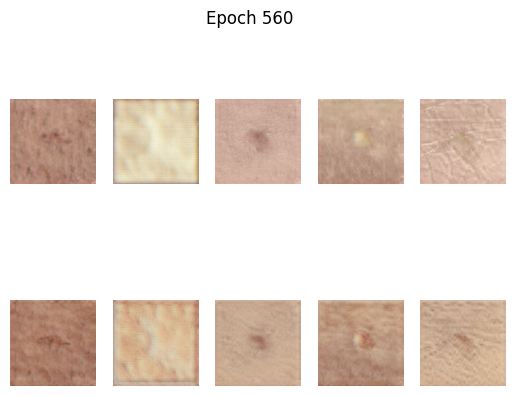

Epoch [561/1000], Step [0/197], Gen G Loss: 3.0424, Gen F Loss: 1.6401, Disc X Loss: 0.0156, Disc Y Loss: 0.0005
Epoch [561/1000], Step [100/197], Gen G Loss: 3.3797, Gen F Loss: 1.0804, Disc X Loss: 2.1431, Disc Y Loss: 0.0035
Epoch [562/1000], Step [0/197], Gen G Loss: 2.7265, Gen F Loss: 2.2309, Disc X Loss: 0.0015, Disc Y Loss: 0.0004
Epoch [562/1000], Step [100/197], Gen G Loss: 2.5022, Gen F Loss: 1.0823, Disc X Loss: 0.0581, Disc Y Loss: 0.0200
Epoch [563/1000], Step [0/197], Gen G Loss: 2.6889, Gen F Loss: 0.6702, Disc X Loss: 0.3632, Disc Y Loss: 0.0008
Epoch [563/1000], Step [100/197], Gen G Loss: 3.2861, Gen F Loss: 1.8916, Disc X Loss: 0.0298, Disc Y Loss: 0.0003
Epoch [564/1000], Step [0/197], Gen G Loss: 2.4780, Gen F Loss: 0.8526, Disc X Loss: 0.1547, Disc Y Loss: 0.0025
Epoch [564/1000], Step [100/197], Gen G Loss: 2.2816, Gen F Loss: 2.2492, Disc X Loss: 0.1065, Disc Y Loss: 0.0049
Epoch [565/1000], Step [0/197], Gen G Loss: 2.3602, Gen F Loss: 1.0930, Disc X Loss: 0.1

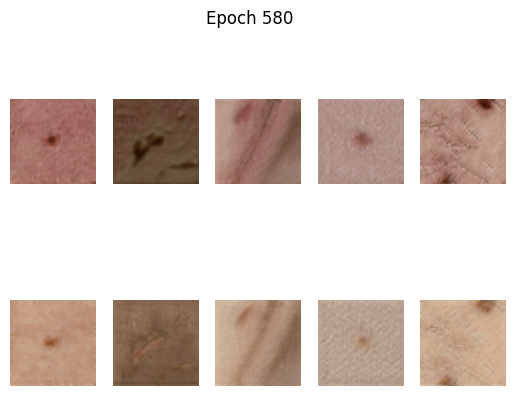

Epoch [581/1000], Step [0/197], Gen G Loss: 3.1822, Gen F Loss: 0.5947, Disc X Loss: 0.6441, Disc Y Loss: 0.0001
Epoch [581/1000], Step [100/197], Gen G Loss: 4.2184, Gen F Loss: 2.0565, Disc X Loss: 0.1049, Disc Y Loss: 0.0000
Epoch [582/1000], Step [0/197], Gen G Loss: 4.1935, Gen F Loss: 1.4726, Disc X Loss: 0.0999, Disc Y Loss: 0.0000
Epoch [582/1000], Step [100/197], Gen G Loss: 2.2216, Gen F Loss: 2.2497, Disc X Loss: 0.0013, Disc Y Loss: 0.0029
Epoch [583/1000], Step [0/197], Gen G Loss: 4.7008, Gen F Loss: 2.3794, Disc X Loss: 0.0095, Disc Y Loss: 0.0001
Epoch [583/1000], Step [100/197], Gen G Loss: 3.1659, Gen F Loss: 1.0195, Disc X Loss: 0.0841, Disc Y Loss: 0.0004
Epoch [584/1000], Step [0/197], Gen G Loss: 2.0400, Gen F Loss: 1.2399, Disc X Loss: 0.0214, Disc Y Loss: 0.0145
Epoch [584/1000], Step [100/197], Gen G Loss: 3.8864, Gen F Loss: 1.7922, Disc X Loss: 0.0072, Disc Y Loss: 0.0001
Epoch [585/1000], Step [0/197], Gen G Loss: 3.8089, Gen F Loss: 2.3254, Disc X Loss: 0.0

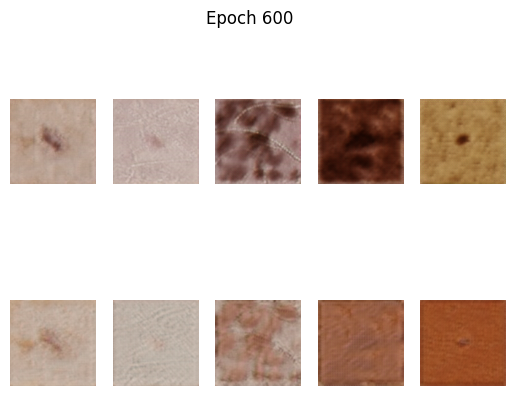

Epoch [601/1000], Step [0/197], Gen G Loss: 2.9985, Gen F Loss: 1.4969, Disc X Loss: 0.0209, Disc Y Loss: 0.0002
Epoch [601/1000], Step [100/197], Gen G Loss: 2.6935, Gen F Loss: 1.8387, Disc X Loss: 0.0078, Disc Y Loss: 0.0004
Epoch [602/1000], Step [0/197], Gen G Loss: 2.8979, Gen F Loss: 0.8651, Disc X Loss: 0.0986, Disc Y Loss: 0.0028
Epoch [602/1000], Step [100/197], Gen G Loss: 2.5580, Gen F Loss: 1.6115, Disc X Loss: 0.0234, Disc Y Loss: 0.0004
Epoch [603/1000], Step [0/197], Gen G Loss: 3.0294, Gen F Loss: 2.0907, Disc X Loss: 0.0011, Disc Y Loss: 0.0352
Epoch [603/1000], Step [100/197], Gen G Loss: 2.8727, Gen F Loss: 1.1574, Disc X Loss: 0.0650, Disc Y Loss: 0.0004
Epoch [604/1000], Step [0/197], Gen G Loss: 3.5910, Gen F Loss: 2.7288, Disc X Loss: 0.5943, Disc Y Loss: 0.0004
Epoch [604/1000], Step [100/197], Gen G Loss: 3.3001, Gen F Loss: 3.1576, Disc X Loss: 0.0393, Disc Y Loss: 0.0001
Epoch [605/1000], Step [0/197], Gen G Loss: 4.7083, Gen F Loss: 2.8151, Disc X Loss: 0.0

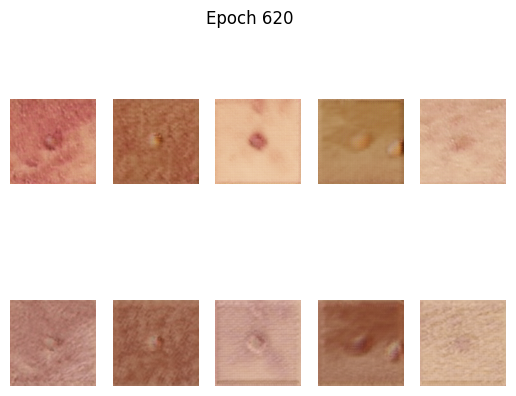

Epoch [621/1000], Step [0/197], Gen G Loss: 3.3407, Gen F Loss: 0.5098, Disc X Loss: 0.4541, Disc Y Loss: 0.0002
Epoch [621/1000], Step [100/197], Gen G Loss: 1.9283, Gen F Loss: 2.1469, Disc X Loss: 0.0054, Disc Y Loss: 0.0182
Epoch [622/1000], Step [0/197], Gen G Loss: 4.2916, Gen F Loss: 1.9326, Disc X Loss: 0.0222, Disc Y Loss: 0.0013
Epoch [622/1000], Step [100/197], Gen G Loss: 3.7358, Gen F Loss: 1.9546, Disc X Loss: 0.0020, Disc Y Loss: 0.0001
Epoch [623/1000], Step [0/197], Gen G Loss: 3.6475, Gen F Loss: 1.4636, Disc X Loss: 0.0167, Disc Y Loss: 0.0033
Epoch [623/1000], Step [100/197], Gen G Loss: 3.1612, Gen F Loss: 1.3296, Disc X Loss: 0.0480, Disc Y Loss: 0.0007
Epoch [624/1000], Step [0/197], Gen G Loss: 2.9576, Gen F Loss: 2.3802, Disc X Loss: 0.0005, Disc Y Loss: 0.0007
Epoch [624/1000], Step [100/197], Gen G Loss: 2.9817, Gen F Loss: 1.7287, Disc X Loss: 0.0072, Disc Y Loss: 0.0093
Epoch [625/1000], Step [0/197], Gen G Loss: 4.1463, Gen F Loss: 2.1753, Disc X Loss: 0.0

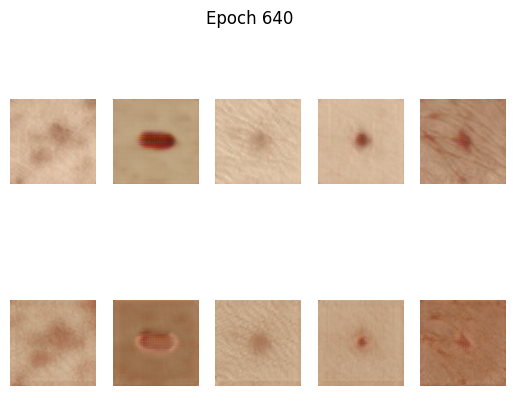

Epoch [641/1000], Step [0/197], Gen G Loss: 4.9868, Gen F Loss: 2.2524, Disc X Loss: 0.0189, Disc Y Loss: 0.0001
Epoch [641/1000], Step [100/197], Gen G Loss: 2.4922, Gen F Loss: 1.5558, Disc X Loss: 0.4212, Disc Y Loss: 0.0005
Epoch [642/1000], Step [0/197], Gen G Loss: 4.1391, Gen F Loss: 2.3618, Disc X Loss: 0.0028, Disc Y Loss: 0.0001
Epoch [642/1000], Step [100/197], Gen G Loss: 3.1678, Gen F Loss: 1.0016, Disc X Loss: 0.0856, Disc Y Loss: 0.0008
Epoch [643/1000], Step [0/197], Gen G Loss: 4.1113, Gen F Loss: 1.8652, Disc X Loss: 0.0113, Disc Y Loss: 0.0004
Epoch [643/1000], Step [100/197], Gen G Loss: 4.2842, Gen F Loss: 2.0873, Disc X Loss: 0.0014, Disc Y Loss: 0.0000
Epoch [644/1000], Step [0/197], Gen G Loss: 4.7914, Gen F Loss: 2.2224, Disc X Loss: 0.0052, Disc Y Loss: 0.0001
Epoch [644/1000], Step [100/197], Gen G Loss: 4.5294, Gen F Loss: 2.5775, Disc X Loss: 0.0007, Disc Y Loss: 0.0001
Epoch [645/1000], Step [0/197], Gen G Loss: 3.1153, Gen F Loss: 2.1966, Disc X Loss: 0.0

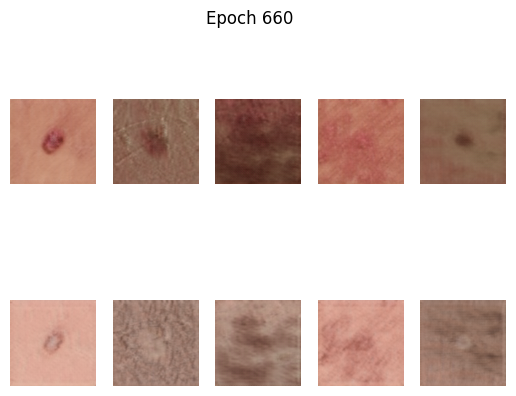

Epoch [661/1000], Step [0/197], Gen G Loss: 4.4310, Gen F Loss: 0.3216, Disc X Loss: 1.0994, Disc Y Loss: 0.0000
Epoch [661/1000], Step [100/197], Gen G Loss: 2.7738, Gen F Loss: 1.2477, Disc X Loss: 0.6833, Disc Y Loss: 0.0011
Epoch [662/1000], Step [0/197], Gen G Loss: 2.9508, Gen F Loss: 0.8949, Disc X Loss: 0.0643, Disc Y Loss: 0.0004
Epoch [662/1000], Step [100/197], Gen G Loss: 3.6331, Gen F Loss: 1.4576, Disc X Loss: 0.0379, Disc Y Loss: 0.0550
Epoch [663/1000], Step [0/197], Gen G Loss: 3.3733, Gen F Loss: 1.7319, Disc X Loss: 0.0906, Disc Y Loss: 0.0003
Epoch [663/1000], Step [100/197], Gen G Loss: 2.5474, Gen F Loss: 1.9445, Disc X Loss: 0.0018, Disc Y Loss: 0.0086
Epoch [664/1000], Step [0/197], Gen G Loss: 3.8519, Gen F Loss: 1.7878, Disc X Loss: 0.0509, Disc Y Loss: 0.0001
Epoch [664/1000], Step [100/197], Gen G Loss: 4.3966, Gen F Loss: 1.6090, Disc X Loss: 0.3009, Disc Y Loss: 0.0077
Epoch [665/1000], Step [0/197], Gen G Loss: 4.1957, Gen F Loss: 2.6166, Disc X Loss: 0.0

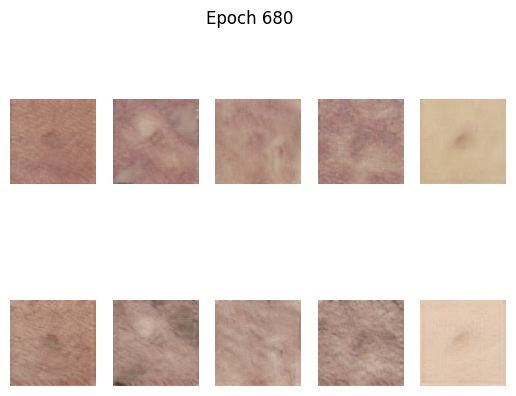

Epoch [681/1000], Step [0/197], Gen G Loss: 3.4836, Gen F Loss: 2.1395, Disc X Loss: 0.0043, Disc Y Loss: 0.0015
Epoch [681/1000], Step [100/197], Gen G Loss: 2.9430, Gen F Loss: 1.2739, Disc X Loss: 0.0311, Disc Y Loss: 0.0046
Epoch [682/1000], Step [0/197], Gen G Loss: 2.4323, Gen F Loss: 1.3825, Disc X Loss: 0.0244, Disc Y Loss: 0.2226
Epoch [682/1000], Step [100/197], Gen G Loss: 4.0323, Gen F Loss: 0.8536, Disc X Loss: 0.1287, Disc Y Loss: 0.0023
Epoch [683/1000], Step [0/197], Gen G Loss: 3.8436, Gen F Loss: 2.4936, Disc X Loss: 0.0002, Disc Y Loss: 0.0000
Epoch [683/1000], Step [100/197], Gen G Loss: 2.8071, Gen F Loss: 0.9239, Disc X Loss: 0.1323, Disc Y Loss: 0.0015
Epoch [684/1000], Step [0/197], Gen G Loss: 3.9369, Gen F Loss: 2.6416, Disc X Loss: 0.0003, Disc Y Loss: 0.0000
Epoch [684/1000], Step [100/197], Gen G Loss: 3.4053, Gen F Loss: 1.9954, Disc X Loss: 0.0035, Disc Y Loss: 0.0312
Epoch [685/1000], Step [0/197], Gen G Loss: 5.5529, Gen F Loss: 1.4026, Disc X Loss: 0.0

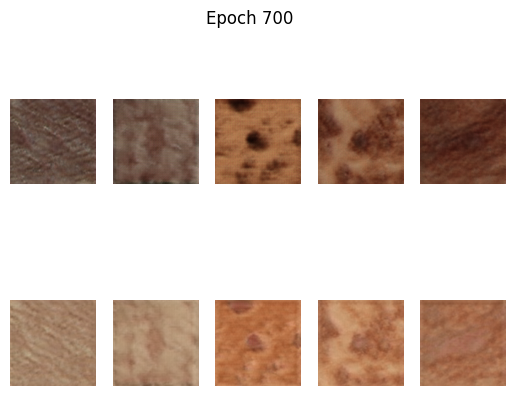

Epoch [701/1000], Step [0/197], Gen G Loss: 2.8071, Gen F Loss: 1.1729, Disc X Loss: 0.0393, Disc Y Loss: 0.0319
Epoch [701/1000], Step [100/197], Gen G Loss: 4.4747, Gen F Loss: 2.7906, Disc X Loss: 0.0001, Disc Y Loss: 0.0017
Epoch [702/1000], Step [0/197], Gen G Loss: 1.6327, Gen F Loss: 0.3490, Disc X Loss: 0.7345, Disc Y Loss: 0.0614
Epoch [702/1000], Step [100/197], Gen G Loss: 2.2678, Gen F Loss: 1.1907, Disc X Loss: 0.1069, Disc Y Loss: 0.0013
Epoch [703/1000], Step [0/197], Gen G Loss: 2.7073, Gen F Loss: 2.3571, Disc X Loss: 0.0012, Disc Y Loss: 0.0021
Epoch [703/1000], Step [100/197], Gen G Loss: 3.7028, Gen F Loss: 2.3452, Disc X Loss: 0.0005, Disc Y Loss: 0.0007
Epoch [704/1000], Step [0/197], Gen G Loss: 2.6075, Gen F Loss: 1.3589, Disc X Loss: 0.0440, Disc Y Loss: 0.0015
Epoch [704/1000], Step [100/197], Gen G Loss: 2.6591, Gen F Loss: 1.4978, Disc X Loss: 0.1655, Disc Y Loss: 0.0019
Epoch [705/1000], Step [0/197], Gen G Loss: 2.8894, Gen F Loss: 2.2438, Disc X Loss: 0.0

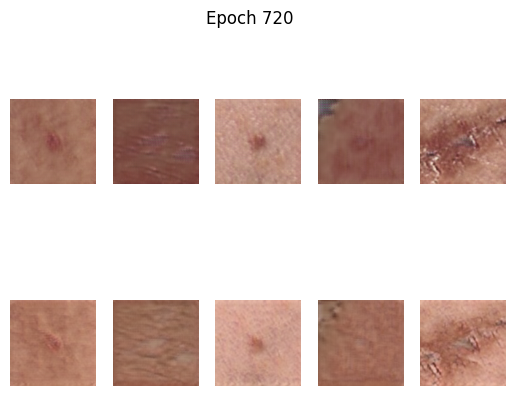

Epoch [721/1000], Step [0/197], Gen G Loss: 4.4343, Gen F Loss: 1.8000, Disc X Loss: 0.0335, Disc Y Loss: 0.0002
Epoch [721/1000], Step [100/197], Gen G Loss: 1.6774, Gen F Loss: 1.9248, Disc X Loss: 0.0042, Disc Y Loss: 0.0246
Epoch [722/1000], Step [0/197], Gen G Loss: 4.2642, Gen F Loss: 1.6569, Disc X Loss: 0.0396, Disc Y Loss: 0.0000
Epoch [722/1000], Step [100/197], Gen G Loss: 4.6476, Gen F Loss: 2.2142, Disc X Loss: 0.0018, Disc Y Loss: 0.0002
Epoch [723/1000], Step [0/197], Gen G Loss: 2.6374, Gen F Loss: 1.5773, Disc X Loss: 0.0164, Disc Y Loss: 0.0072
Epoch [723/1000], Step [100/197], Gen G Loss: 3.4973, Gen F Loss: 0.5087, Disc X Loss: 0.5300, Disc Y Loss: 0.0002
Epoch [724/1000], Step [0/197], Gen G Loss: 3.4829, Gen F Loss: 1.0805, Disc X Loss: 0.0331, Disc Y Loss: 0.0004
Epoch [724/1000], Step [100/197], Gen G Loss: 4.7290, Gen F Loss: 1.4963, Disc X Loss: 0.0525, Disc Y Loss: 0.0038
Epoch [725/1000], Step [0/197], Gen G Loss: 5.9849, Gen F Loss: 0.7441, Disc X Loss: 0.1

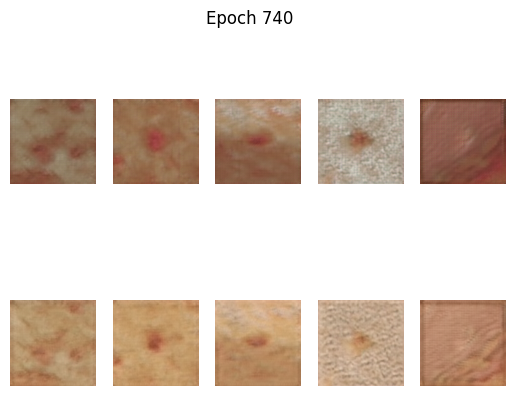

Epoch [741/1000], Step [0/197], Gen G Loss: 4.6137, Gen F Loss: 1.6125, Disc X Loss: 0.0206, Disc Y Loss: 0.0000
Epoch [741/1000], Step [100/197], Gen G Loss: 2.9804, Gen F Loss: 0.6733, Disc X Loss: 0.4995, Disc Y Loss: 0.0632
Epoch [742/1000], Step [0/197], Gen G Loss: 3.8154, Gen F Loss: 1.2034, Disc X Loss: 0.2122, Disc Y Loss: 0.0014
Epoch [742/1000], Step [100/197], Gen G Loss: 4.7356, Gen F Loss: 3.2885, Disc X Loss: 0.0001, Disc Y Loss: 0.0001
Epoch [743/1000], Step [0/197], Gen G Loss: 2.8402, Gen F Loss: 1.9342, Disc X Loss: 0.0081, Disc Y Loss: 0.0016
Epoch [743/1000], Step [100/197], Gen G Loss: 2.4735, Gen F Loss: 0.6882, Disc X Loss: 0.4381, Disc Y Loss: 0.0003
Epoch [744/1000], Step [0/197], Gen G Loss: 2.5248, Gen F Loss: 1.4406, Disc X Loss: 0.8780, Disc Y Loss: 0.0024
Epoch [744/1000], Step [100/197], Gen G Loss: 5.8847, Gen F Loss: 1.3628, Disc X Loss: 0.1251, Disc Y Loss: 0.0004
Epoch [745/1000], Step [0/197], Gen G Loss: 2.6076, Gen F Loss: 2.5407, Disc X Loss: 0.3

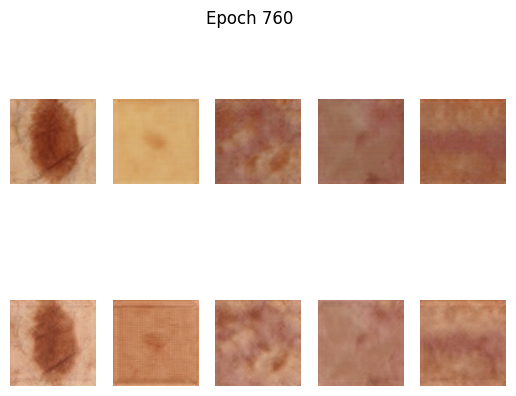

Epoch [761/1000], Step [0/197], Gen G Loss: 4.3297, Gen F Loss: 0.5824, Disc X Loss: 0.3989, Disc Y Loss: 0.0000
Epoch [761/1000], Step [100/197], Gen G Loss: 2.9206, Gen F Loss: 1.2799, Disc X Loss: 0.0556, Disc Y Loss: 0.0003
Epoch [762/1000], Step [0/197], Gen G Loss: 3.0279, Gen F Loss: 2.9346, Disc X Loss: 0.0492, Disc Y Loss: 0.0032
Epoch [762/1000], Step [100/197], Gen G Loss: 2.9330, Gen F Loss: 0.8686, Disc X Loss: 0.1045, Disc Y Loss: 0.0006
Epoch [763/1000], Step [0/197], Gen G Loss: 4.6487, Gen F Loss: 1.1842, Disc X Loss: 0.0867, Disc Y Loss: 0.0002
Epoch [763/1000], Step [100/197], Gen G Loss: 5.0483, Gen F Loss: 1.7312, Disc X Loss: 0.0046, Disc Y Loss: 0.0001
Epoch [764/1000], Step [0/197], Gen G Loss: 4.0599, Gen F Loss: 1.3829, Disc X Loss: 0.0195, Disc Y Loss: 0.0000
Epoch [764/1000], Step [100/197], Gen G Loss: 0.4763, Gen F Loss: 2.1696, Disc X Loss: 0.0099, Disc Y Loss: 2.4775
Epoch [765/1000], Step [0/197], Gen G Loss: 2.1184, Gen F Loss: 2.0823, Disc X Loss: 0.0

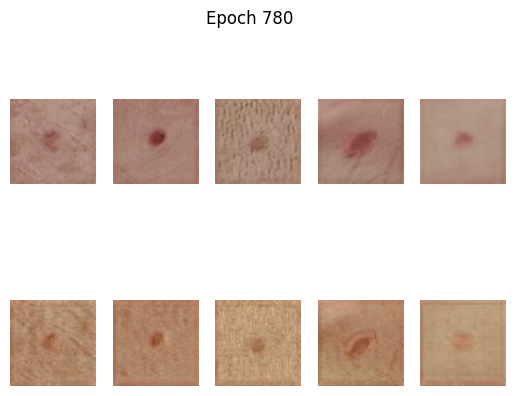

Epoch [781/1000], Step [0/197], Gen G Loss: 3.9504, Gen F Loss: 2.1667, Disc X Loss: 0.0039, Disc Y Loss: 0.0001
Epoch [781/1000], Step [100/197], Gen G Loss: 4.3886, Gen F Loss: 1.5531, Disc X Loss: 0.0366, Disc Y Loss: 0.0007
Epoch [782/1000], Step [0/197], Gen G Loss: 4.6916, Gen F Loss: 2.5863, Disc X Loss: 0.0004, Disc Y Loss: 0.0000
Epoch [782/1000], Step [100/197], Gen G Loss: 3.6433, Gen F Loss: 2.6442, Disc X Loss: 0.0006, Disc Y Loss: 0.0001
Epoch [783/1000], Step [0/197], Gen G Loss: 3.6043, Gen F Loss: 2.5725, Disc X Loss: 0.0441, Disc Y Loss: 0.0026
Epoch [783/1000], Step [100/197], Gen G Loss: 3.1592, Gen F Loss: 1.5943, Disc X Loss: 0.0157, Disc Y Loss: 0.0017
Epoch [784/1000], Step [0/197], Gen G Loss: 3.4958, Gen F Loss: 2.0095, Disc X Loss: 0.0051, Disc Y Loss: 0.0001
Epoch [784/1000], Step [100/197], Gen G Loss: 3.2536, Gen F Loss: 2.2906, Disc X Loss: 0.0044, Disc Y Loss: 0.0020
Epoch [785/1000], Step [0/197], Gen G Loss: 2.4659, Gen F Loss: 1.8529, Disc X Loss: 0.0

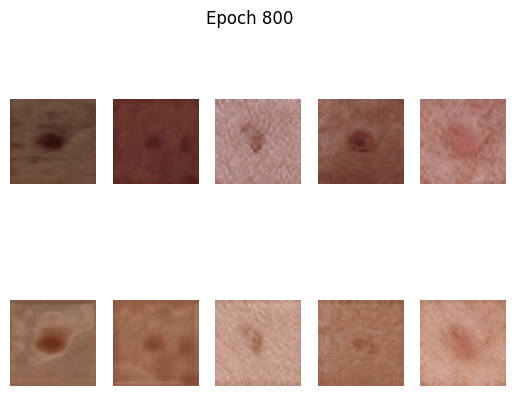

Epoch [801/1000], Step [0/197], Gen G Loss: 3.5960, Gen F Loss: 0.7907, Disc X Loss: 0.2039, Disc Y Loss: 0.0003
Epoch [801/1000], Step [100/197], Gen G Loss: 4.2249, Gen F Loss: 1.6289, Disc X Loss: 0.0272, Disc Y Loss: 0.0000
Epoch [802/1000], Step [0/197], Gen G Loss: 4.7289, Gen F Loss: 2.8030, Disc X Loss: 0.0001, Disc Y Loss: 0.0002
Epoch [802/1000], Step [100/197], Gen G Loss: 3.3217, Gen F Loss: 1.4232, Disc X Loss: 0.0257, Disc Y Loss: 0.0003
Epoch [803/1000], Step [0/197], Gen G Loss: 3.1968, Gen F Loss: 2.7685, Disc X Loss: 0.0001, Disc Y Loss: 0.0026
Epoch [803/1000], Step [100/197], Gen G Loss: 3.5663, Gen F Loss: 2.2793, Disc X Loss: 0.0008, Disc Y Loss: 0.0004
Epoch [804/1000], Step [0/197], Gen G Loss: 5.1948, Gen F Loss: 1.3860, Disc X Loss: 0.0235, Disc Y Loss: 0.0007
Epoch [804/1000], Step [100/197], Gen G Loss: 3.3148, Gen F Loss: 1.3254, Disc X Loss: 0.0454, Disc Y Loss: 0.0005
Epoch [805/1000], Step [0/197], Gen G Loss: 4.4151, Gen F Loss: 4.2142, Disc X Loss: 0.0

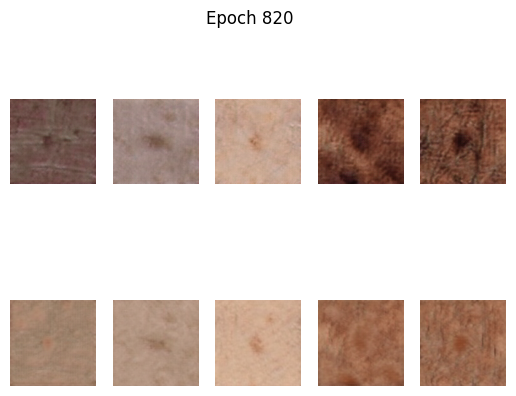

Epoch [821/1000], Step [0/197], Gen G Loss: 4.5816, Gen F Loss: 1.9716, Disc X Loss: 0.1790, Disc Y Loss: 0.0010
Epoch [821/1000], Step [100/197], Gen G Loss: 4.1279, Gen F Loss: 2.0063, Disc X Loss: 0.0147, Disc Y Loss: 0.0001
Epoch [822/1000], Step [0/197], Gen G Loss: 3.1528, Gen F Loss: 1.1346, Disc X Loss: 0.3687, Disc Y Loss: 0.0017
Epoch [822/1000], Step [100/197], Gen G Loss: 4.1999, Gen F Loss: 1.4820, Disc X Loss: 0.0152, Disc Y Loss: 0.0001
Epoch [823/1000], Step [0/197], Gen G Loss: 2.3023, Gen F Loss: 2.1314, Disc X Loss: 0.0019, Disc Y Loss: 0.0017
Epoch [823/1000], Step [100/197], Gen G Loss: 4.9192, Gen F Loss: 2.1128, Disc X Loss: 0.0092, Disc Y Loss: 0.0001
Epoch [824/1000], Step [0/197], Gen G Loss: 4.4408, Gen F Loss: 1.7737, Disc X Loss: 0.0295, Disc Y Loss: 0.0015
Epoch [824/1000], Step [100/197], Gen G Loss: 4.5959, Gen F Loss: 1.7670, Disc X Loss: 0.0101, Disc Y Loss: 0.0002
Epoch [825/1000], Step [0/197], Gen G Loss: 5.0067, Gen F Loss: 0.7840, Disc X Loss: 0.2

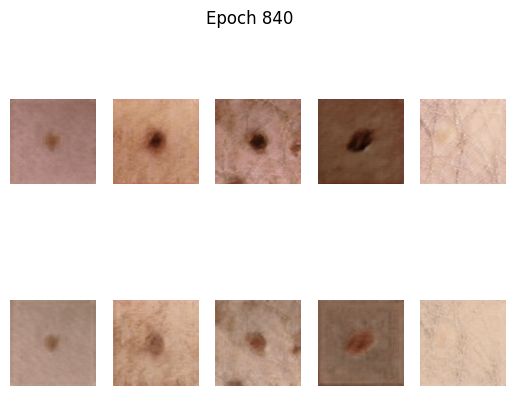

Epoch [841/1000], Step [0/197], Gen G Loss: 3.7120, Gen F Loss: 1.5982, Disc X Loss: 0.0170, Disc Y Loss: 0.0000
Epoch [841/1000], Step [100/197], Gen G Loss: 4.2053, Gen F Loss: 0.9949, Disc X Loss: 0.0967, Disc Y Loss: 0.0011
Epoch [842/1000], Step [0/197], Gen G Loss: 2.3044, Gen F Loss: 1.7494, Disc X Loss: 0.0079, Disc Y Loss: 0.0061
Epoch [842/1000], Step [100/197], Gen G Loss: 3.9543, Gen F Loss: 0.9354, Disc X Loss: 0.0658, Disc Y Loss: 0.0057
Epoch [843/1000], Step [0/197], Gen G Loss: 3.4892, Gen F Loss: 1.5232, Disc X Loss: 0.0477, Disc Y Loss: 0.0101
Epoch [843/1000], Step [100/197], Gen G Loss: 2.9535, Gen F Loss: 1.6740, Disc X Loss: 0.2084, Disc Y Loss: 0.0379
Epoch [844/1000], Step [0/197], Gen G Loss: 2.9175, Gen F Loss: 2.0743, Disc X Loss: 1.1171, Disc Y Loss: 0.0007
Epoch [844/1000], Step [100/197], Gen G Loss: 2.9897, Gen F Loss: 0.5076, Disc X Loss: 0.5229, Disc Y Loss: 0.0021
Epoch [845/1000], Step [0/197], Gen G Loss: 4.6196, Gen F Loss: 1.4182, Disc X Loss: 0.0

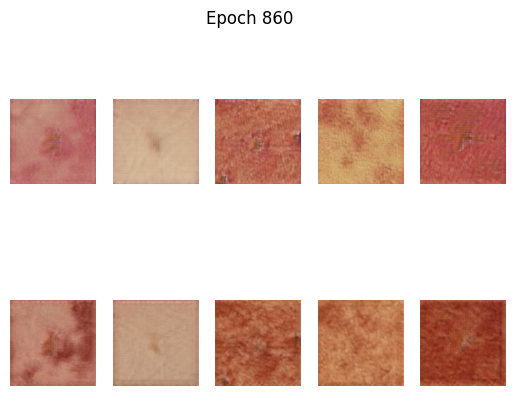

Epoch [861/1000], Step [0/197], Gen G Loss: 4.2837, Gen F Loss: 1.9649, Disc X Loss: 0.0025, Disc Y Loss: 0.0001
Epoch [861/1000], Step [100/197], Gen G Loss: 3.1135, Gen F Loss: 2.1961, Disc X Loss: 0.0037, Disc Y Loss: 0.0003
Epoch [862/1000], Step [0/197], Gen G Loss: 4.1333, Gen F Loss: 1.4054, Disc X Loss: 0.0298, Disc Y Loss: 0.0007
Epoch [862/1000], Step [100/197], Gen G Loss: 3.2191, Gen F Loss: 2.8710, Disc X Loss: 0.0015, Disc Y Loss: 0.0001
Epoch [863/1000], Step [0/197], Gen G Loss: 2.1901, Gen F Loss: 1.6293, Disc X Loss: 0.1095, Disc Y Loss: 0.0033
Epoch [863/1000], Step [100/197], Gen G Loss: 2.7453, Gen F Loss: 1.5097, Disc X Loss: 0.1028, Disc Y Loss: 0.0003
Epoch [864/1000], Step [0/197], Gen G Loss: 2.7632, Gen F Loss: 1.2170, Disc X Loss: 0.0646, Disc Y Loss: 0.0013
Epoch [864/1000], Step [100/197], Gen G Loss: 2.9619, Gen F Loss: 1.9026, Disc X Loss: 0.0132, Disc Y Loss: 0.0003
Epoch [865/1000], Step [0/197], Gen G Loss: 2.6184, Gen F Loss: 0.6257, Disc X Loss: 0.3

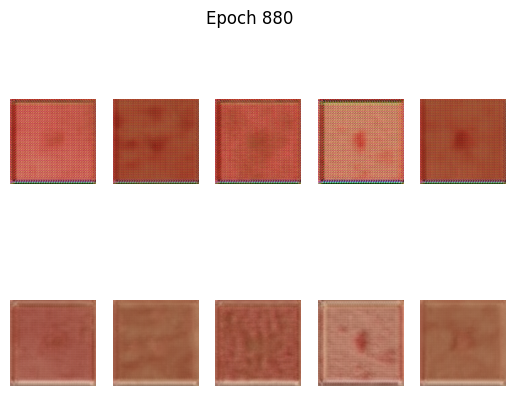

Epoch [881/1000], Step [0/197], Gen G Loss: 6.4843, Gen F Loss: 2.3952, Disc X Loss: 0.0556, Disc Y Loss: 0.0000
Epoch [881/1000], Step [100/197], Gen G Loss: 4.2291, Gen F Loss: 1.6494, Disc X Loss: 0.0067, Disc Y Loss: 0.0000
Epoch [882/1000], Step [0/197], Gen G Loss: 2.0817, Gen F Loss: 2.3593, Disc X Loss: 0.2899, Disc Y Loss: 0.0028
Epoch [882/1000], Step [100/197], Gen G Loss: 3.9837, Gen F Loss: 1.7362, Disc X Loss: 0.0056, Disc Y Loss: 0.0001
Epoch [883/1000], Step [0/197], Gen G Loss: 8.4538, Gen F Loss: 1.0685, Disc X Loss: 0.1457, Disc Y Loss: 0.0001
Epoch [883/1000], Step [100/197], Gen G Loss: 7.5224, Gen F Loss: 2.4703, Disc X Loss: 0.0095, Disc Y Loss: 0.0000
Epoch [884/1000], Step [0/197], Gen G Loss: 5.6162, Gen F Loss: 2.1685, Disc X Loss: 0.0876, Disc Y Loss: 0.0000
Epoch [884/1000], Step [100/197], Gen G Loss: 4.6612, Gen F Loss: 1.1187, Disc X Loss: 0.1106, Disc Y Loss: 0.0000
Epoch [885/1000], Step [0/197], Gen G Loss: 4.4583, Gen F Loss: 2.2649, Disc X Loss: 0.0

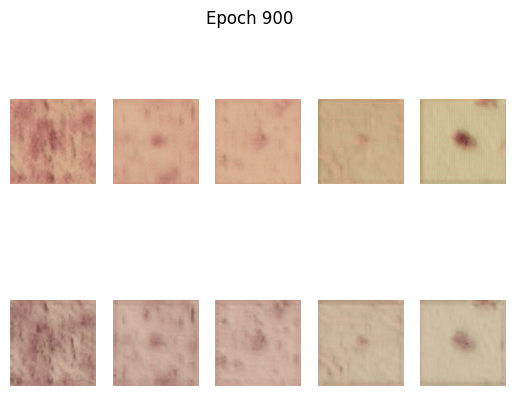

Epoch [901/1000], Step [0/197], Gen G Loss: 4.8601, Gen F Loss: 1.2683, Disc X Loss: 0.0418, Disc Y Loss: 0.0000
Epoch [901/1000], Step [100/197], Gen G Loss: 3.0052, Gen F Loss: 2.0776, Disc X Loss: 0.0432, Disc Y Loss: 0.0005
Epoch [902/1000], Step [0/197], Gen G Loss: 4.7305, Gen F Loss: 2.0771, Disc X Loss: 0.0056, Disc Y Loss: 0.0001
Epoch [902/1000], Step [100/197], Gen G Loss: 5.0271, Gen F Loss: 2.1877, Disc X Loss: 0.0009, Disc Y Loss: 0.0002
Epoch [903/1000], Step [0/197], Gen G Loss: 4.9501, Gen F Loss: 1.8972, Disc X Loss: 0.0794, Disc Y Loss: 0.0000
Epoch [903/1000], Step [100/197], Gen G Loss: 4.2945, Gen F Loss: 1.7712, Disc X Loss: 0.0381, Disc Y Loss: 0.0000
Epoch [904/1000], Step [0/197], Gen G Loss: 4.6437, Gen F Loss: 0.7830, Disc X Loss: 0.5530, Disc Y Loss: 0.0000
Epoch [904/1000], Step [100/197], Gen G Loss: 3.3059, Gen F Loss: 2.2910, Disc X Loss: 0.0071, Disc Y Loss: 0.0008
Epoch [905/1000], Step [0/197], Gen G Loss: 4.5477, Gen F Loss: 1.0101, Disc X Loss: 0.1

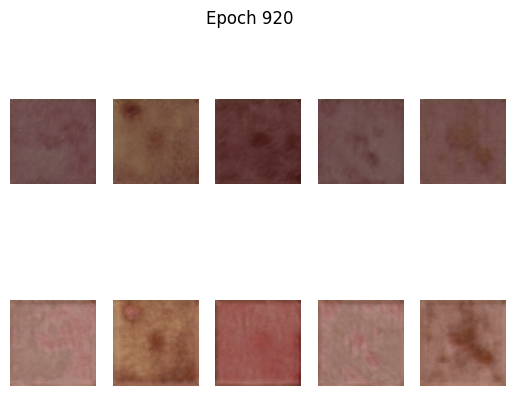

Epoch [921/1000], Step [0/197], Gen G Loss: 4.4124, Gen F Loss: 1.5638, Disc X Loss: 0.0176, Disc Y Loss: 0.0000
Epoch [921/1000], Step [100/197], Gen G Loss: 4.7797, Gen F Loss: 2.0229, Disc X Loss: 0.0342, Disc Y Loss: 0.0000
Epoch [922/1000], Step [0/197], Gen G Loss: 3.3122, Gen F Loss: 2.8384, Disc X Loss: 0.0266, Disc Y Loss: 0.0000
Epoch [922/1000], Step [100/197], Gen G Loss: 3.6837, Gen F Loss: 2.1956, Disc X Loss: 0.0019, Disc Y Loss: 0.0006
Epoch [923/1000], Step [0/197], Gen G Loss: 2.3449, Gen F Loss: 2.2093, Disc X Loss: 0.0013, Disc Y Loss: 0.1650
Epoch [923/1000], Step [100/197], Gen G Loss: 3.7818, Gen F Loss: 2.5819, Disc X Loss: 0.0405, Disc Y Loss: 0.0003
Epoch [924/1000], Step [0/197], Gen G Loss: 4.2487, Gen F Loss: 1.8839, Disc X Loss: 0.0231, Disc Y Loss: 0.0000
Epoch [924/1000], Step [100/197], Gen G Loss: 2.6734, Gen F Loss: 2.4008, Disc X Loss: 0.0023, Disc Y Loss: 0.0161
Epoch [925/1000], Step [0/197], Gen G Loss: 4.4671, Gen F Loss: 1.9189, Disc X Loss: 0.0

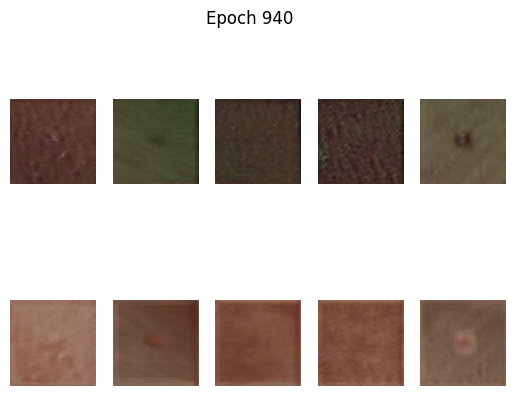

Epoch [941/1000], Step [0/197], Gen G Loss: 4.1233, Gen F Loss: 2.4001, Disc X Loss: 0.0065, Disc Y Loss: 0.0001
Epoch [941/1000], Step [100/197], Gen G Loss: 2.8490, Gen F Loss: 2.2954, Disc X Loss: 0.0044, Disc Y Loss: 0.0048
Epoch [942/1000], Step [0/197], Gen G Loss: 3.4954, Gen F Loss: 1.2983, Disc X Loss: 0.0632, Disc Y Loss: 0.0004
Epoch [942/1000], Step [100/197], Gen G Loss: 4.2093, Gen F Loss: 2.2666, Disc X Loss: 0.0332, Disc Y Loss: 0.0002
Epoch [943/1000], Step [0/197], Gen G Loss: 4.6873, Gen F Loss: 1.8316, Disc X Loss: 0.0044, Disc Y Loss: 0.0002
Epoch [943/1000], Step [100/197], Gen G Loss: 3.3931, Gen F Loss: 1.2957, Disc X Loss: 0.0327, Disc Y Loss: 0.0003
Epoch [944/1000], Step [0/197], Gen G Loss: 3.1286, Gen F Loss: 1.4472, Disc X Loss: 0.0495, Disc Y Loss: 0.0005
Epoch [944/1000], Step [100/197], Gen G Loss: 3.8294, Gen F Loss: 2.0378, Disc X Loss: 0.0266, Disc Y Loss: 0.0001
Epoch [945/1000], Step [0/197], Gen G Loss: 3.7947, Gen F Loss: 2.6392, Disc X Loss: 0.0

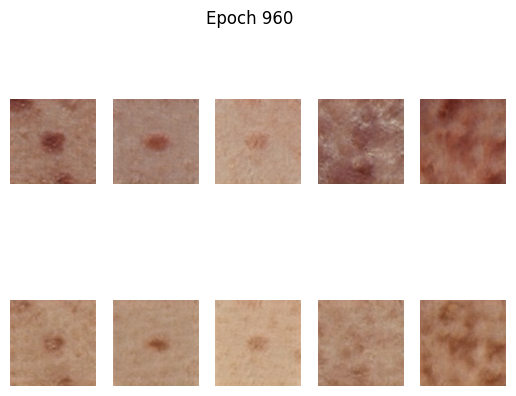

Epoch [961/1000], Step [0/197], Gen G Loss: 3.8406, Gen F Loss: 1.9545, Disc X Loss: 0.0037, Disc Y Loss: 0.0426
Epoch [961/1000], Step [100/197], Gen G Loss: 3.4046, Gen F Loss: 2.0390, Disc X Loss: 0.0077, Disc Y Loss: 0.0005
Epoch [962/1000], Step [0/197], Gen G Loss: 2.2753, Gen F Loss: 1.5496, Disc X Loss: 0.0225, Disc Y Loss: 0.0425
Epoch [962/1000], Step [100/197], Gen G Loss: 3.6994, Gen F Loss: 2.1877, Disc X Loss: 0.0059, Disc Y Loss: 0.0007
Epoch [963/1000], Step [0/197], Gen G Loss: 4.0326, Gen F Loss: 2.0411, Disc X Loss: 0.0161, Disc Y Loss: 0.0000
Epoch [963/1000], Step [100/197], Gen G Loss: 4.0005, Gen F Loss: 2.4616, Disc X Loss: 0.0012, Disc Y Loss: 0.0000
Epoch [964/1000], Step [0/197], Gen G Loss: 4.1614, Gen F Loss: 2.6234, Disc X Loss: 0.0190, Disc Y Loss: 0.0001
Epoch [964/1000], Step [100/197], Gen G Loss: 4.3243, Gen F Loss: 1.8672, Disc X Loss: 0.0099, Disc Y Loss: 0.0017
Epoch [965/1000], Step [0/197], Gen G Loss: 3.1311, Gen F Loss: 1.5204, Disc X Loss: 0.0

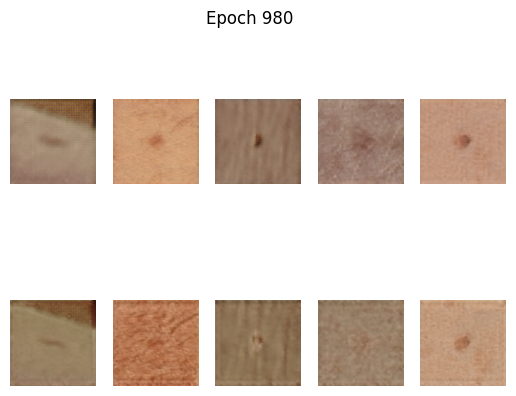

Epoch [981/1000], Step [0/197], Gen G Loss: 4.1142, Gen F Loss: 1.2607, Disc X Loss: 0.0416, Disc Y Loss: 0.0000
Epoch [981/1000], Step [100/197], Gen G Loss: 3.7988, Gen F Loss: 1.7066, Disc X Loss: 0.0066, Disc Y Loss: 0.0007
Epoch [982/1000], Step [0/197], Gen G Loss: 3.2192, Gen F Loss: 1.2938, Disc X Loss: 0.0588, Disc Y Loss: 0.0004
Epoch [982/1000], Step [100/197], Gen G Loss: 3.9017, Gen F Loss: 1.6307, Disc X Loss: 0.0151, Disc Y Loss: 0.0014
Epoch [983/1000], Step [0/197], Gen G Loss: 3.7762, Gen F Loss: 3.1829, Disc X Loss: 0.0136, Disc Y Loss: 0.0005
Epoch [983/1000], Step [100/197], Gen G Loss: 4.0162, Gen F Loss: 1.3735, Disc X Loss: 0.0267, Disc Y Loss: 0.0000
Epoch [984/1000], Step [0/197], Gen G Loss: 3.2510, Gen F Loss: 0.8245, Disc X Loss: 0.1716, Disc Y Loss: 0.0001
Epoch [984/1000], Step [100/197], Gen G Loss: 4.4994, Gen F Loss: 1.7531, Disc X Loss: 0.0122, Disc Y Loss: 0.0026
Epoch [985/1000], Step [0/197], Gen G Loss: 4.1918, Gen F Loss: 1.4869, Disc X Loss: 0.0

In [10]:
train_cycle_gan(epochs=1000)


# Function to Visualise Original Vs Generated 

In [13]:
def visualise_original_vs_generated(real_images, generated_images, num_images=10):
    num_images = min(num_images, real_images.size(0), generated_images.size(0))
    plt.figure(figsize=(20, 8)) 
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Rescale from [-1, 1] to [0, 1]
        plt.title("Real")
        plt.axis("off")
        
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i].cpu().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)  # Rescale from [-1, 1] to [0, 1]
        plt.title("Generated")
        plt.axis("off")
    plt.show()

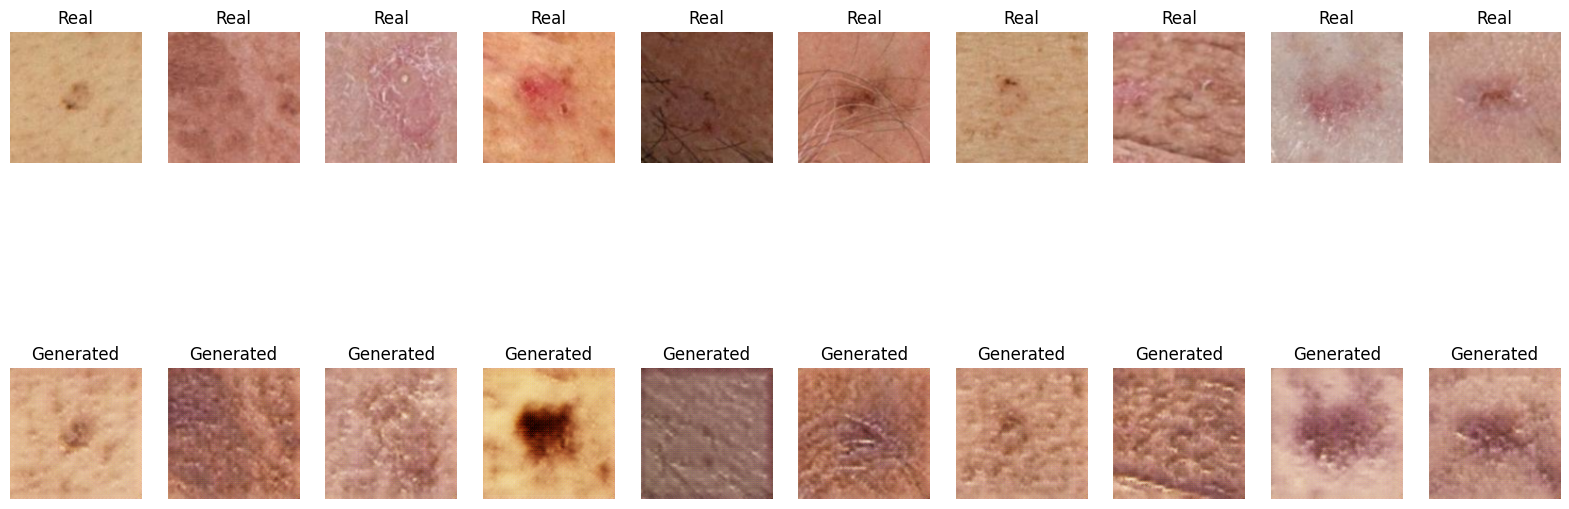

In [24]:
batch_size = 10  
benign_loader = DataLoader(benign_dataset, batch_size=batch_size, shuffle=True)
malignant_loader = DataLoader(malignant_dataset, batch_size=batch_size, shuffle=True)
real_malignant_images = next(iter(malignant_loader)).to(device)
generated_malignant_images = generator_g(real_malignant_images)
visualise_original_vs_generated(real_malignant_images, generated_malignant_images, num_images=10)

# Saving the model

In [21]:
output_dir = "/home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/model"
os.makedirs(output_dir, exist_ok=True)

generator_g_save_path = os.path.join(output_dir, "generator_g.pth")
generator_f_save_path = os.path.join(output_dir, "generator_f.pth")
discriminator_x_save_path = os.path.join(output_dir, "discriminator_x.pth")
discriminator_y_save_path = os.path.join(output_dir, "discriminator_y.pth")

torch.save(generator_g.state_dict(), generator_g_save_path)
print(f"Generator G model saved to {generator_g_save_path}")

torch.save(generator_f.state_dict(), generator_f_save_path)
print(f"Generator F model saved to {generator_f_save_path}")

torch.save(discriminator_x.state_dict(), discriminator_x_save_path)
print(f"Discriminator X model saved to {discriminator_x_save_path}")

torch.save(discriminator_y.state_dict(), discriminator_y_save_path)
print(f"Discriminator Y model saved to {discriminator_y_save_path}")

Generator G model saved to /home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/model/generator_g.pth
Generator F model saved to /home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/model/generator_f.pth
Discriminator X model saved to /home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/model/discriminator_x.pth
Discriminator Y model saved to /home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/model/discriminator_y.pth


# Function to calculate FID for a specified number of batches and generating images.  

In [ ]:
output_dir = "/home/msp/Naveen/Thesis/Dataset/new_labelled_image_data/FID_FINAL_IMGS"
os.makedirs(output_dir, exist_ok=True)

def calculate_fid(generated_images, real_images, device):
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_activations(images, model):
        images = images.to(device)
        with torch.no_grad():
            pred = model(images)[0]
        return pred.cpu().numpy()

    real_activations = get_activations(real_images, inception_model)
    generated_activations = get_activations(generated_images, inception_model)
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(generated_activations, axis=0), np.cov(generated_activations, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = np.dot(diff, diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid_score

def generate_and_save_images(generator, data_loader, num_images, batch_size, output_dir, fid_threshold, device):
    generator.eval()
    generated_images = []

    for i in range(num_images // batch_size):
        benign_images = next(iter(data_loader)).to(device)
        with torch.no_grad():
            fake_images = generator(benign_images).cpu()
        generated_images.append(fake_images)

        for j, img in enumerate(fake_images):
            img_path = os.path.join(output_dir, f'generated_{i * batch_size + j + 1}.png')
            save_image(img, img_path, normalize=True)

    generated_images = torch.cat(generated_images, dim=0)
    real_malignant_images = next(iter(data_loader)).to(device)
    fid_score = calculate_fid(generated_images, real_malignant_images, device)
    print(f"FID Score: {fid_score}")

    if fid_score < fid_threshold:
        print(f"FID threshold met ({fid_score} < {fid_threshold}). Stopping generation.")
        return

    generator.train()

num_images_to_generate = 3000
fid_threshold = 30.0  
generate_and_save_images(generator_g, malignant_loader, num_images_to_generate, batch_size=10, output_dir=output_dir, fid_threshold=fid_threshold, device=device)
